# Multiple output from LSTM model

## Operator 1

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import warnings
from keras.models import Sequential # type: ignore
from keras.layers import Dense, LSTM, Dropout # type: ignore
from sklearn.preprocessing import MinMaxScaler

In [60]:
rsrp_colors = ['#384959', '#6A89A7', '#88BDF2', '#BDDDFC']
rsrq_colors = ['#614419', '#B37E2E', '#DB9A39', '#FFB343']
sinr_colors = ['#135E4B', '#4CB572', '#A1D8B5', '#CCDCDB']
mode_colors = ['#872323', '#C93636', '#E26666', '#F4B6B6']

plt.rcParams.update({'font.size': 14})

### Processing functions

In [61]:
'''
    Reading the dataset and returning two pandas DataFrames:
        The first DataFrame containing every datapoint belonging to the given campaign (if any)
        The second DataFrame containing only one column - the mode (4G or 5G)
'''
def read_dataset(filename, campaigns=None, features=None):
    df = pd.read_csv(filename)
    df = df.loc[:, ~df.columns.str.match('Unnamed')]
    df = df.loc[:, ~df.columns.str.match('Timestamp')]
    df = df.replace('DC', 1)
    df = df.replace('LTE', 0)
    df = df[df['campaign'].str.contains('Driving') | df['campaign'].str.contains('Walking')]

    if campaigns != None:
        df = df[df['campaign'].isin(campaigns)]

    if features == None:
        features = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ', 'campaign']

    features.append('Mode')
    features.append('Latitude')
    features.append('Longitude')
    return df[features]

### LSTM functions

In [62]:
'''
    Returns a numpy array of list 
'''
def series_split_sequences(f, t, n_steps_in, n_steps_out):
    X, y = [], []
    curr_campaign = ''
    for i in range(len(f)):
        # find the end of the pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out

        if out_end_ix > len(f):
            break

        if curr_campaign == '': # set new current campaign if there is no campaign
            curr_campaign = f['campaign'].iloc[i]
        seq_x, seq_y = f[i:end_ix], t[end_ix:out_end_ix]
        if f.iloc[i:out_end_ix]['campaign'].nunique() > 1: # check to see if in transition between two campaigns
            continue
        elif curr_campaign != f['campaign'].iloc[i]: # set new campaign equal to current if this is the campaign we are looping through
            curr_campaign = f['campaign'].iloc[i]
        X.append(seq_x.drop('campaign', axis=1))
        y.append(seq_y)

    return np.array(X), np.array(y)


'''
    Returns the mean absolute error on each datapoint
'''
def single_point_mae(y_pred, y_true):
    pred_series, true_series = [], []
    mae_list = []

    for i in range(len(y_pred)):
        mae = []
        for k in range(len(y_pred[i])):
            pred_series.append(y_pred[i][k])
            true_series.append(y_true[i][k])
            mae.append(np.abs(y_pred[i][k] - y_true[i][k]))
        mae_list.append(mae)

    pred_series, true_series = np.array(pred_series), np.array(true_series)

    return np.mean(np.abs(pred_series - true_series)), np.array(mae_list)


def long_short_term_memory(train, test, target_feature:str, features:list, n_steps_in=5, n_steps_out=1, units=[5, 10]):

    features.remove('campaign')

    idx_target = features.index(target_feature)

    scaler = MinMaxScaler()
    train[features] = scaler.fit_transform(train[features])
    test[features] = scaler.transform(test[features])

    X, y = series_split_sequences(train, train[target_feature], n_steps_in, n_steps_out)
    X_test, y_test = series_split_sequences(test, test[target_feature], n_steps_in, n_steps_out)

    train_idx = 4 * len(y) // 5

    X_train, y_train = X[0 : train_idx], y[0 : train_idx]
    X_val, y_val = X[train_idx ::], y[train_idx ::]

    model = Sequential()
    if len(units) > 1:
        for unit in units[0:-1]:
            model.add(LSTM(units=unit,
                        activation='relu', recurrent_activation='sigmoid',
                        return_sequences=True, return_state=False
                        ))
            model.add(Dropout(0.2))
    model.add(LSTM(units=units[-1],
                   activation='relu', recurrent_activation='sigmoid',
                   return_sequences=False, return_state=False
                   ))
    model.add(Dropout(0.2))
    model.add(Dense(n_steps_out, activation='sigmoid'))
    model.compile(loss='mse', optimizer='adam')
    
    history = model.fit(X_train, y_train,
              epochs=100,
              validation_data=(X_val, y_val),
              shuffle=True, verbose=0)   

    scaler_pred = MinMaxScaler()
    scaler_pred.min_, scaler_pred.scale_ = scaler.min_[idx_target], scaler.scale_[idx_target]

    y_pred = model.predict(X_test, verbose=0) 

    y_pred = scaler_pred.inverse_transform(y_pred)
    y_true = scaler_pred.inverse_transform(y_test)
    test[features] = scaler.inverse_transform(test[features])

    train_pred = model.predict(X, verbose=0)

    train_pred = scaler_pred.inverse_transform(train_pred)
    train[features] = scaler.inverse_transform(train[features])
    _, test_y_seq = series_split_sequences(train, train[target_feature], n_steps_in, n_steps_out)
        
    mae = single_point_mae(y_pred, y_true)
    train_mae = single_point_mae(train_pred, test_y_seq)

    results = {'y_pred': y_pred,
               'y_true': y_true,
               'train_pred': train_pred,
               'train_true': y_train,
               'loss' : history.history['loss'],
               'loss_final' : round(history.history['loss'][-1], 5),
               'val_loss' : history.history['val_loss'],
               'val_loss_final' : round(history.history['val_loss'][-1], 5),
               'mae': round(mae[0], 2),
               'list_mae': mae[1],
               'train_mae': round(train_mae[0], 2),
               'train_list_mae': train_mae[1]
               }

    return results


'''
    Plots the mean absolute errors in a boxplot for each signal strength indicator
    Returns a dataframe with mean mae for each timestep for each signal strength indicator
'''
def boxplot_timesteps(results:dict, feature_comb:list, sss_feature_comb:list, n_steps_in:int, n_steps_out:int, operator:str, whiskers=[5, 95], y_lim=None):
    selected_rsrp, selected_sinr, selected_rsrq = feature_comb[0], feature_comb[1], feature_comb[2]
    selected_sss_rsrp, selected_sss_sinr, selected_sss_rsrq = sss_feature_comb[0], sss_feature_comb[1], sss_feature_comb[2]

    rsrp_lstm, sinr_lstm, rsrq_lstm = results[selected_rsrp]['list_mae'], results[selected_sinr]['list_mae'], results[selected_rsrq]['list_mae']
    sss_rsrp_lstm, sss_sinr_lstm, sss_rsrq_lstm = results[selected_sss_rsrp]['list_mae'], results[selected_sss_sinr]['list_mae'], results[selected_sss_rsrq]['list_mae']

    rsrp_lstm_mae, sinr_lstm_mae, rsrq_lstm_mae, sss_rsrp_lstm_mae, sss_sinr_lstm_mae, sss_rsrq_lstm_mae = [], [], [], [], [], []
    mean_rsrp, mean_sinr, mean_rsrq, mean_sss_rsrp, mean_sss_sinr, mean_sss_rsrq = [], [], [], [], [], []

    for i in range(n_steps_out):
        rsrp_lstm_mae.append(rsrp_lstm[:, i])
        mean_rsrp.append(round(np.mean(rsrp_lstm[:, i]), 3))

        sinr_lstm_mae.append(sinr_lstm[:, i])
        mean_sinr.append(round(np.mean(sinr_lstm[:, i]), 3))

        rsrq_lstm_mae.append(rsrq_lstm[:, i])
        mean_rsrq.append(round(np.mean(rsrq_lstm[:, i]), 3))

        sss_rsrp_lstm_mae.append(sss_rsrp_lstm[:, i])
        mean_sss_rsrp.append(round(np.mean(sss_rsrp_lstm[:, i]), 3))

        sss_sinr_lstm_mae.append(sss_sinr_lstm[:, i])
        mean_sss_sinr.append(round(np.mean(sss_sinr_lstm[:, i]), 3))

        sss_rsrq_lstm_mae.append(sss_rsrq_lstm[:, i])
        mean_sss_rsrq.append(round(np.mean(sss_rsrq_lstm[:, i]), 3))
    
    labels = ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th', '11th', '12th', '13th', '14th', '15th', '16th', '17th', '18th', '19th', '20th']

    fig, axes = plt.subplots(2, 3, figsize=(18, 16), sharey=True)
    sns.boxplot(data=rsrp_lstm_mae, color=rsrp_colors[2], ax=axes[0, 0], whis=whiskers)
    axes[0, 0].set_title('Mean absolute errors of RSRP')

    sns.boxplot(data=sinr_lstm_mae, color=sinr_colors[2], ax=axes[0, 1], whis=whiskers)
    axes[0, 1].set_title('Mean absolute errors of SINR')

    sns.boxplot(data=rsrq_lstm_mae, color=rsrq_colors[2], ax=axes[0, 2], whis=whiskers)
    axes[0, 2].set_title('Mean absolute errors of RSRQ')

    sns.boxplot(data=sss_rsrp_lstm_mae, color=rsrp_colors[2], ax=axes[1, 0], whis=whiskers)
    axes[1, 0].set_title('Mean absolute errors of SSS-RSRP')

    sns.boxplot(data=sss_sinr_lstm_mae, color=sinr_colors[2], ax=axes[1, 1], whis=whiskers)
    axes[1, 1].set_title('Mean absolute errors of SSS-SINR')

    sns.boxplot(data=sss_rsrq_lstm_mae, color=rsrq_colors[2], ax=axes[1, 2], whis=whiskers)
    axes[1, 2].set_title('Mean absolute errors of SSS-RSRQ')

    axes[0, 0].set_ylim((-0.2, y_lim))

    for ax in axes.flat:
        ax.set_ylabel('Mean Absolute Error')
        ax.set_xlabel('Timestep')
        ax.set_xticks(range(n_steps_out))
        ax.set_xticklabels(labels[0:n_steps_out])
        
    plt.suptitle(f'{n_steps_in} steps in, {n_steps_out} steps out\n{operator}', fontsize=18, fontweight='semibold')

    plt.show()

    means = {
        'RSRP': mean_rsrp,
        'SINR': mean_sinr,
        'RSRQ': mean_rsrq,
        'SSS-RSRP': mean_sss_rsrp,
        'SSS-SINR': mean_sss_sinr,
        'SSS-RSRQ': mean_sss_rsrq
    }

    fig.subplots_adjust(wspace=0.5, hspace=10)

    means = pd.DataFrame(means, index=labels[0:n_steps_out]).T

    return fig, means

### Overlapping campaigns

* Ping_UNIDATA_4G5G_TIM_Driving_Viale_Marconi, Ping_UNIDATA_4G5G_TIM_Driving_Viale_Marconi_Test_2_No_Flight_Mode, Ping_UNIDATA_4G5G_TIM_Driving_Palasport_to_Via_Appia_End_No_Flight_Mode, Interactivity_gaming_4G5G_TIM_Driving_Viale_Marconi_No_Flight_Mode, Interactivity_gaming_4G5G_TIM_Driving_Palasport_to_Via_Appia_End_No_Flight_Mode, Capacity_Ookla_UNIDATA_4G5G_TIM_Driving_Viale_Marconi

* Ping_UNIDATA_4G5G_TIM_Walking_Termini_to_DIET, Ping_UNIDATA_4G5G_TIM_Walking_DIET_to_Termini, Ping_UNIDATA_4G5G_TIM_Walking_DIET_to_Labicana_Hotel, Interactivity_gaming_4G5G_TIM_Walking_Termini_to_DIET_Test_2_No_Flight_Mode, Capacity_Ookla_UNIDATA_4G5G_TIM_Walking_DIET_to_Labicana_Hotel

* Ping_UNIDATA_4G5G_TIM_Walking_Tuscolana_Stat_Appia, Ping_UNIDATA_4G5G_TIM_Walking_Tuscolana_Stat_Appia_Part_2, Interactivity_gaming_4G5G_TIM_Driving_Tuscolana_Stat_Appia_No_Flight_Mode, Capacity_Ookla_UNIDATA_4G5G_TIM_Walking_Tuscolana_Stat_Appia, Capacity_Ookla_4G5G_TIM_Driving_Tuscolana_Stat_Appia_No_Flight_Mode

* Ping_UNIDATA_4G5G_TIM_Driving_Luca, Interactivity_gaming_4G5G_TIM_Driving_Luca, Capacity_Ookla_4G5G_Tim_Driving_Luca

### Parameters

In [63]:
tf.random.set_seed(4567)

In [64]:
overlap_1 = ['Ping_UNIDATA_4G5G_TIM_Driving_Viale_Marconi_Test_2_No_Flight_Mode',
             'Ping_UNIDATA_4G5G_TIM_Driving_Viale_Marconi', 
             'Interactivity_gaming_4G5G_TIM_Driving_Viale_Marconi_No_Flight_Mode', 
             'Capacity_Ookla_UNIDATA_4G5G_TIM_Driving_Viale_Marconi',
             'Interactivity_gaming_4G5G_TIM_Driving_Palasport_to_Via_Appia_End_No_Flight_Mode',
             'Ping_UNIDATA_4G5G_TIM_Driving_Palasport_to_Via_Appia_End_No_Flight_Mode']

overlap_2 = ['Ping_UNIDATA_4G5G_TIM_Walking_Termini_to_DIET', 
             'Ping_UNIDATA_4G5G_TIM_Walking_DIET_to_Termini', 
             'Ping_UNIDATA_4G5G_TIM_Walking_DIET_to_Labicana_Hotel', 
             'Interactivity_gaming_4G5G_TIM_Walking_Termini_to_DIET_Test_2_No_Flight_Mode', 
             'Capacity_Ookla_UNIDATA_4G5G_TIM_Walking_DIET_to_Labicana_Hotel']

overlap_3 = ['Ping_UNIDATA_4G5G_TIM_Walking_Tuscolana_Stat_Appia', 
             'Ping_UNIDATA_4G5G_TIM_Walking_Tuscolana_Stat_Appia_Part_2', 
             'Interactivity_gaming_4G5G_TIM_Driving_Tuscolana_Stat_Appia_No_Flight_Mode', 
             'Capacity_Ookla_UNIDATA_4G5G_TIM_Walking_Tuscolana_Stat_Appia', 
             'Capacity_Ookla_4G5G_TIM_Driving_Tuscolana_Stat_Appia_No_Flight_Mode']

overlap_4 = ['Ping_UNIDATA_4G5G_TIM_Driving_Luca', 
             'Interactivity_gaming_4G5G_TIM_Driving_Luca', 
             'Capacity_Ookla_4G5G_Tim_Driving_Luca']

In [65]:
train = read_dataset('datasets/Op1_merged.csv', campaigns=[overlap_1[1]])
test = read_dataset('datasets/Op1_merged.csv', campaigns=[overlap_1[0]])
operator = 'Operator 1'

In [66]:
target_features = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']
feature_selection = [['RSRP'], ['SINR'], ['RSRQ'], 
                    #  ['RSRP', 'SINR'], ['RSRP', 'RSRQ'], ['SINR', 'RSRQ'], 
                    #  ['RSRP', 'SINR', 'RSRQ'],
                     ['SSS_RSRP'], ['SSS_SINR'], ['SSS_RSRQ'],
                    #  ['SSS_RSRP', 'SSS_SINR'], ['SSS_RSRP', 'SSS_RSRQ'], ['SSS_SINR', 'SSS_RSRQ'], 
                    #  ['SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ'],
                     ['RSRP', 'SSS_RSRP'], ['SINR', 'SSS_SINR'], ['RSRQ', 'SSS_RSRQ']]#, 
                    #  ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']]

feature_comb = ['RSRP -> RSRP', 'SINR -> SINR', 'RSRQ -> RSRQ']
sss_feature_comb = ['SSS_RSRP -> SSS_RSRP', 'SSS_SINR -> SSS_SINR', 'SSS_RSRQ -> SSS_RSRQ']

## Testing n units for m layers

In [67]:
# parameters
n_steps_in = 2
n_steps_out = 5
units = [[5, 5], [5, 10], [10, 10], [5, 5, 5], [5, 5, 10], [5, 10, 5], [10, 5, 5], [5, 10, 10], [10, 5, 10], [10, 10, 5], [10, 10, 10], [10, 20, 10], [5, 5, 5, 5], [10, 10, 10, 10]]
features = ['RSRP', 'SSS_RSRP']
 
results = {}

for unit in units:
    layers = ' ->'.join(map(str, unit))
    warnings.simplefilter(action='ignore')
    features.extend(['campaign'])
    results[layers] = long_short_term_memory(train=train[features], test=test[features], target_feature='RSRP', features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=unit)

df_results = pd.DataFrame.from_dict(results, orient='index')
df_results.reset_index(inplace=True)
df_results.rename(columns={'index': 'Combination'}, inplace=True)
df_results = df_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'loss', 'val_loss', 'list_mae', 'train_list_mae'], axis=1)
df_results

,Combination,loss_final,val_loss_final,mae,train_mae
0,5 ->5,0.01145,0.00865,1.43,2.20
1,5 ->10,0.01158,0.00537,2.53,2.81
2,10 ->10,0.00778,0.00711,1.10,1.78
3,5 ->5 ->5,0.01238,0.00833,2.42,3.15
4,5 ->5 ->10,0.01420,0.00753,2.07,3.00
5,5 ->10 ->5,0.01471,0.00676,2.81,3.36
6,10 ->5 ->5,0.01668,0.00804,3.95,4.06
7,5 ->10 ->10,0.01183,0.00604,2.36,2.87
8,10 ->5 ->10,0.01168,0.00684,2.04,2.87
9,10 ->10 ->5,0.01524,0.00705,1.38,2.32


## 2 steps prediction

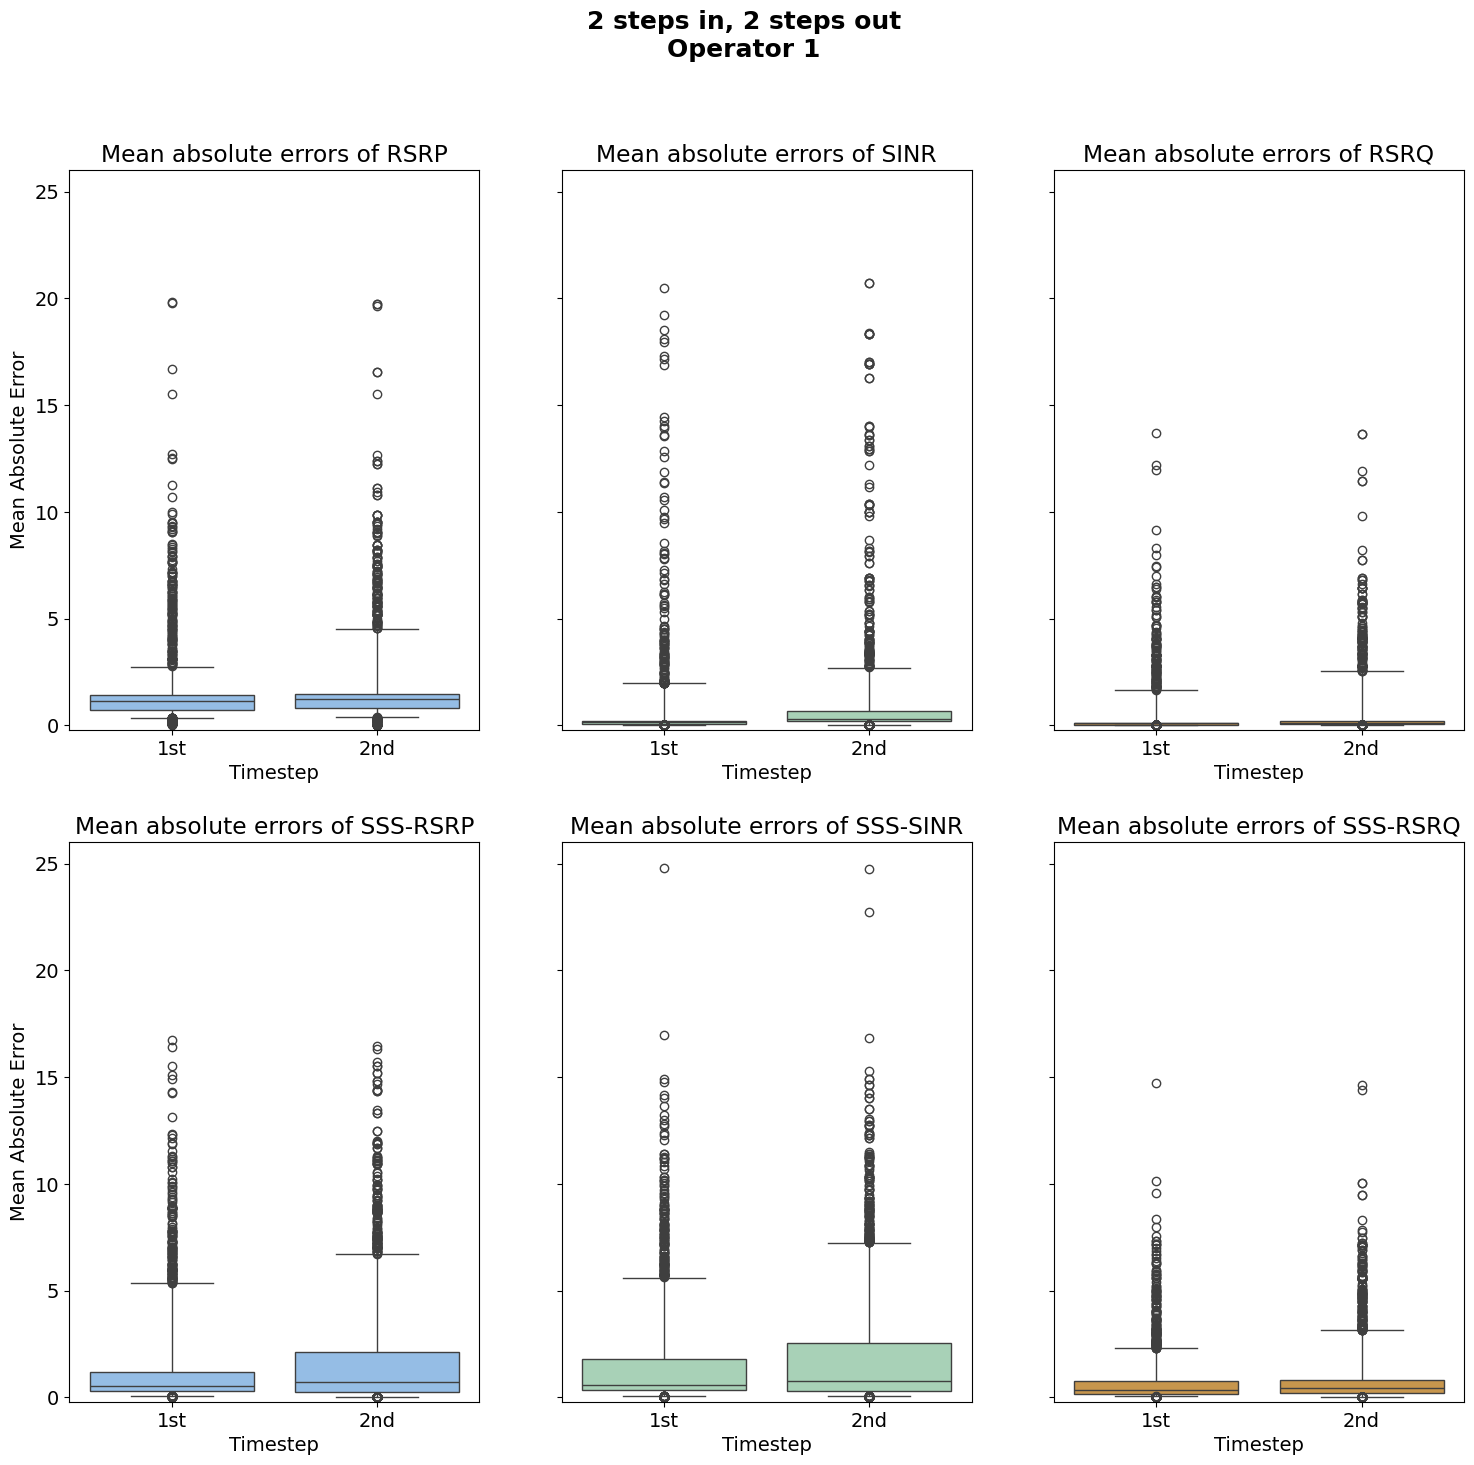

In [68]:
units = [10, 10]
n_steps_in = 2
n_steps_out = 2

lstm_results = {}

for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            used_features = ''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(features)
            used_features = used_features + ' -> ' + target
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
            lstm_results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=units)
            df_lstm_results = pd.DataFrame.from_dict(lstm_results, orient='index')

fig, mae_each_step = boxplot_timesteps(results=lstm_results, feature_comb=feature_comb, sss_feature_comb=sss_feature_comb, n_steps_in=n_steps_in, n_steps_out=n_steps_out, operator=operator)
fig.savefig(r'../latex/plots/lstm/op1_box_2_steps_mae.pdf')

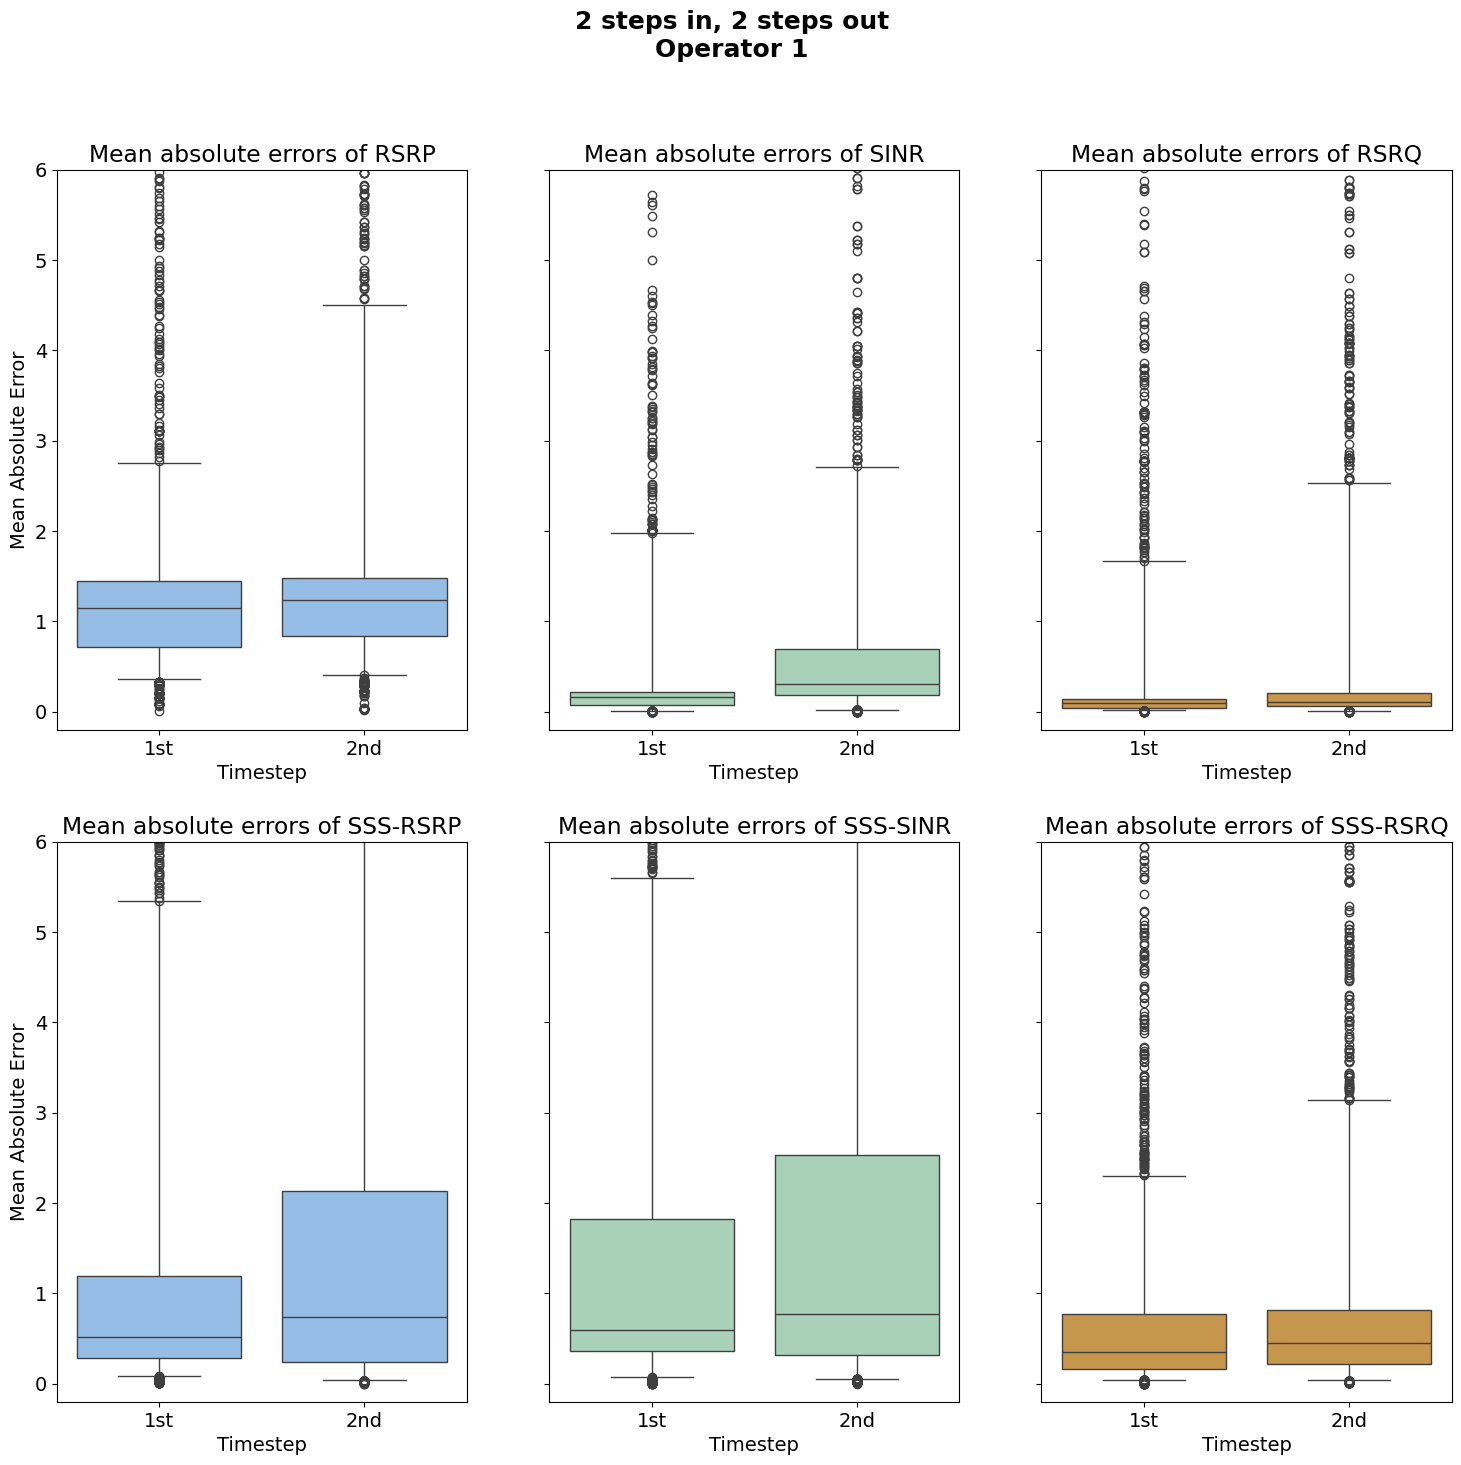

In [69]:
fig, mae_each_step = boxplot_timesteps(results=lstm_results, feature_comb=feature_comb, sss_feature_comb=sss_feature_comb, n_steps_in=n_steps_in, n_steps_out=n_steps_out, operator=operator, y_lim=6)
fig.savefig(r'../latex/plots/lstm/op1_box_2_steps_mae_zoom.pdf')

In [70]:
mae_each_step

,1st,2nd
RSRP,1.297,1.476
SINR,0.517,0.833
RSRQ,0.346,0.466
SSS-RSRP,1.265,1.712
SSS-SINR,1.466,1.877
SSS-RSRQ,0.662,0.817


## 3 Steps Prediction

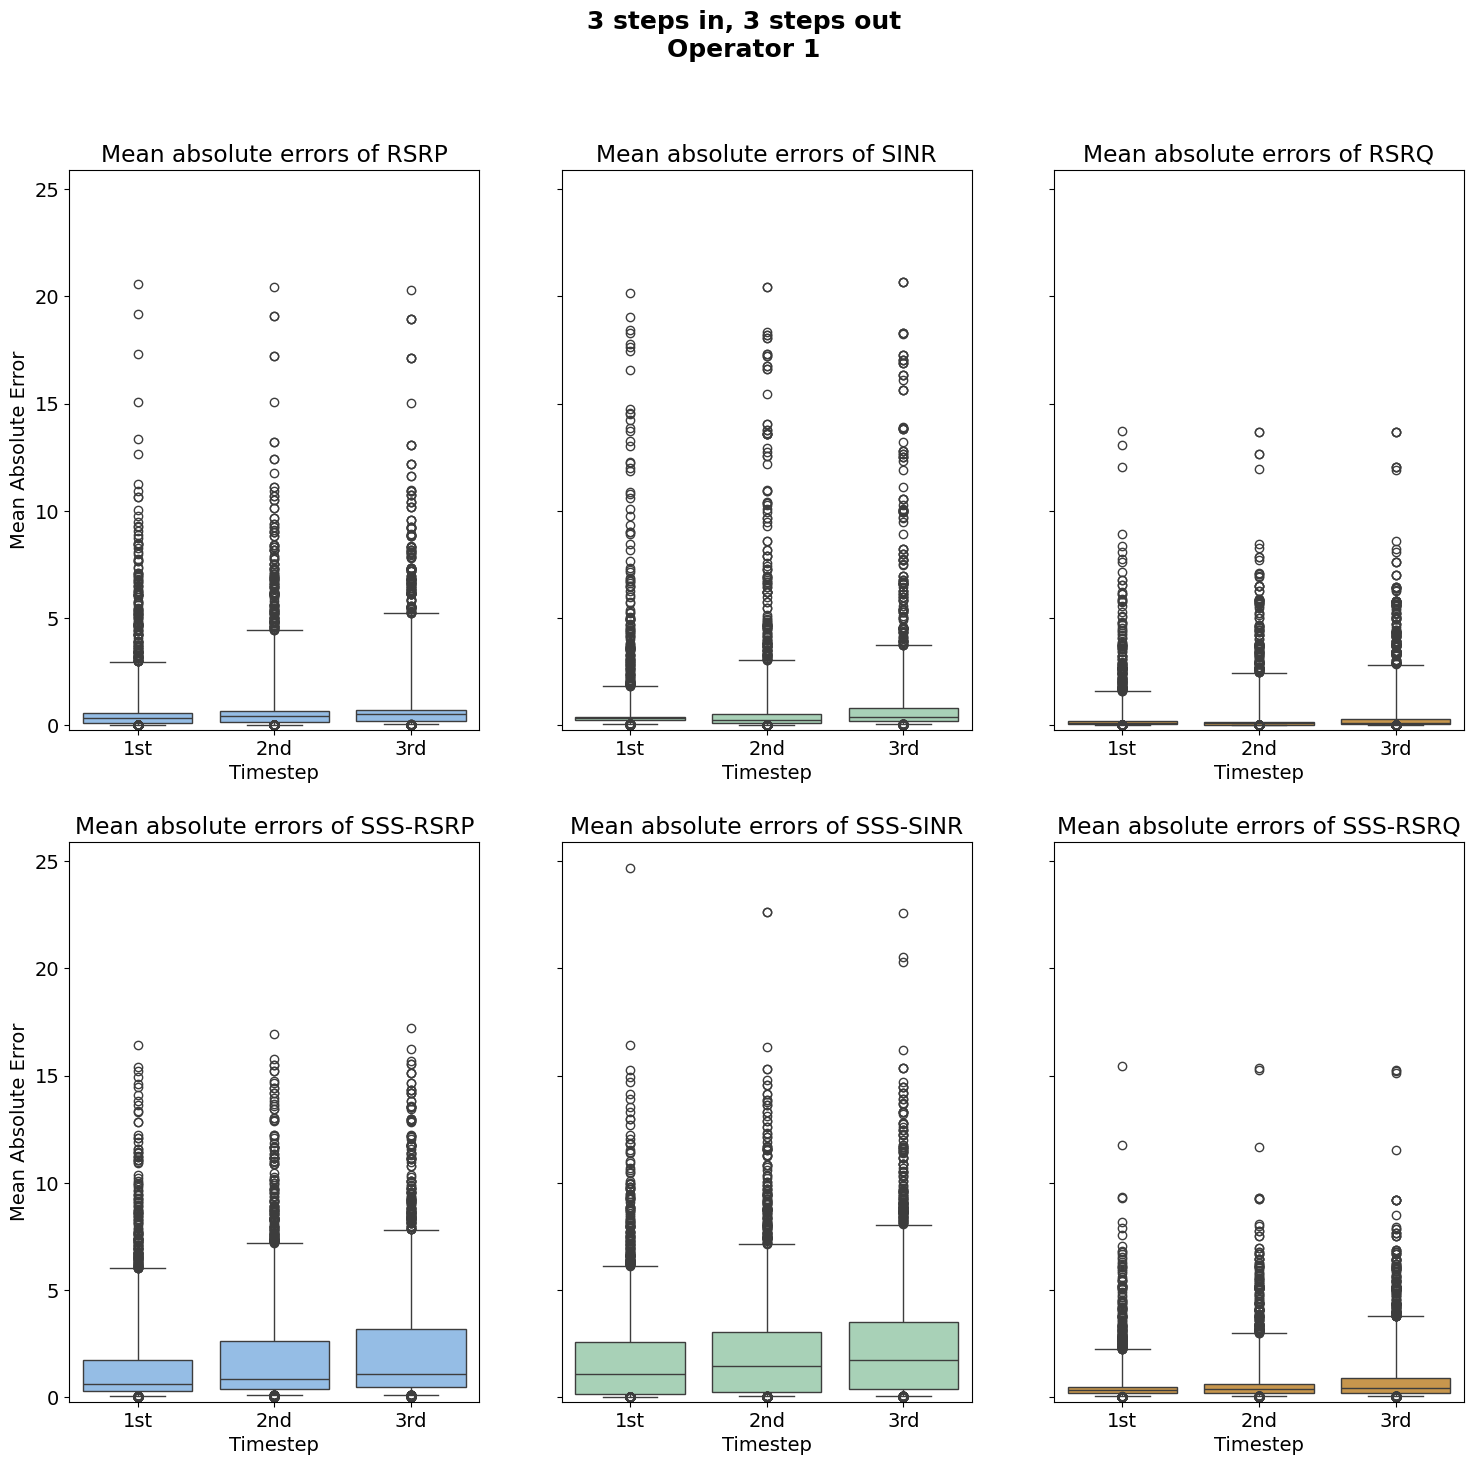

In [71]:
n_steps_in = 3
n_steps_out = 3

lstm_results = {}

for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            used_features = ''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(features)
            used_features = used_features + ' -> ' + target
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
            lstm_results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=units)
            df_lstm_results = pd.DataFrame.from_dict(lstm_results, orient='index')

fig, mae_each_step = boxplot_timesteps(results=lstm_results, feature_comb=feature_comb, sss_feature_comb=sss_feature_comb, n_steps_in=n_steps_in, n_steps_out=n_steps_out, operator=operator)
fig.savefig(r'../latex/plots/lstm/op1_box_3_steps_mae.pdf')

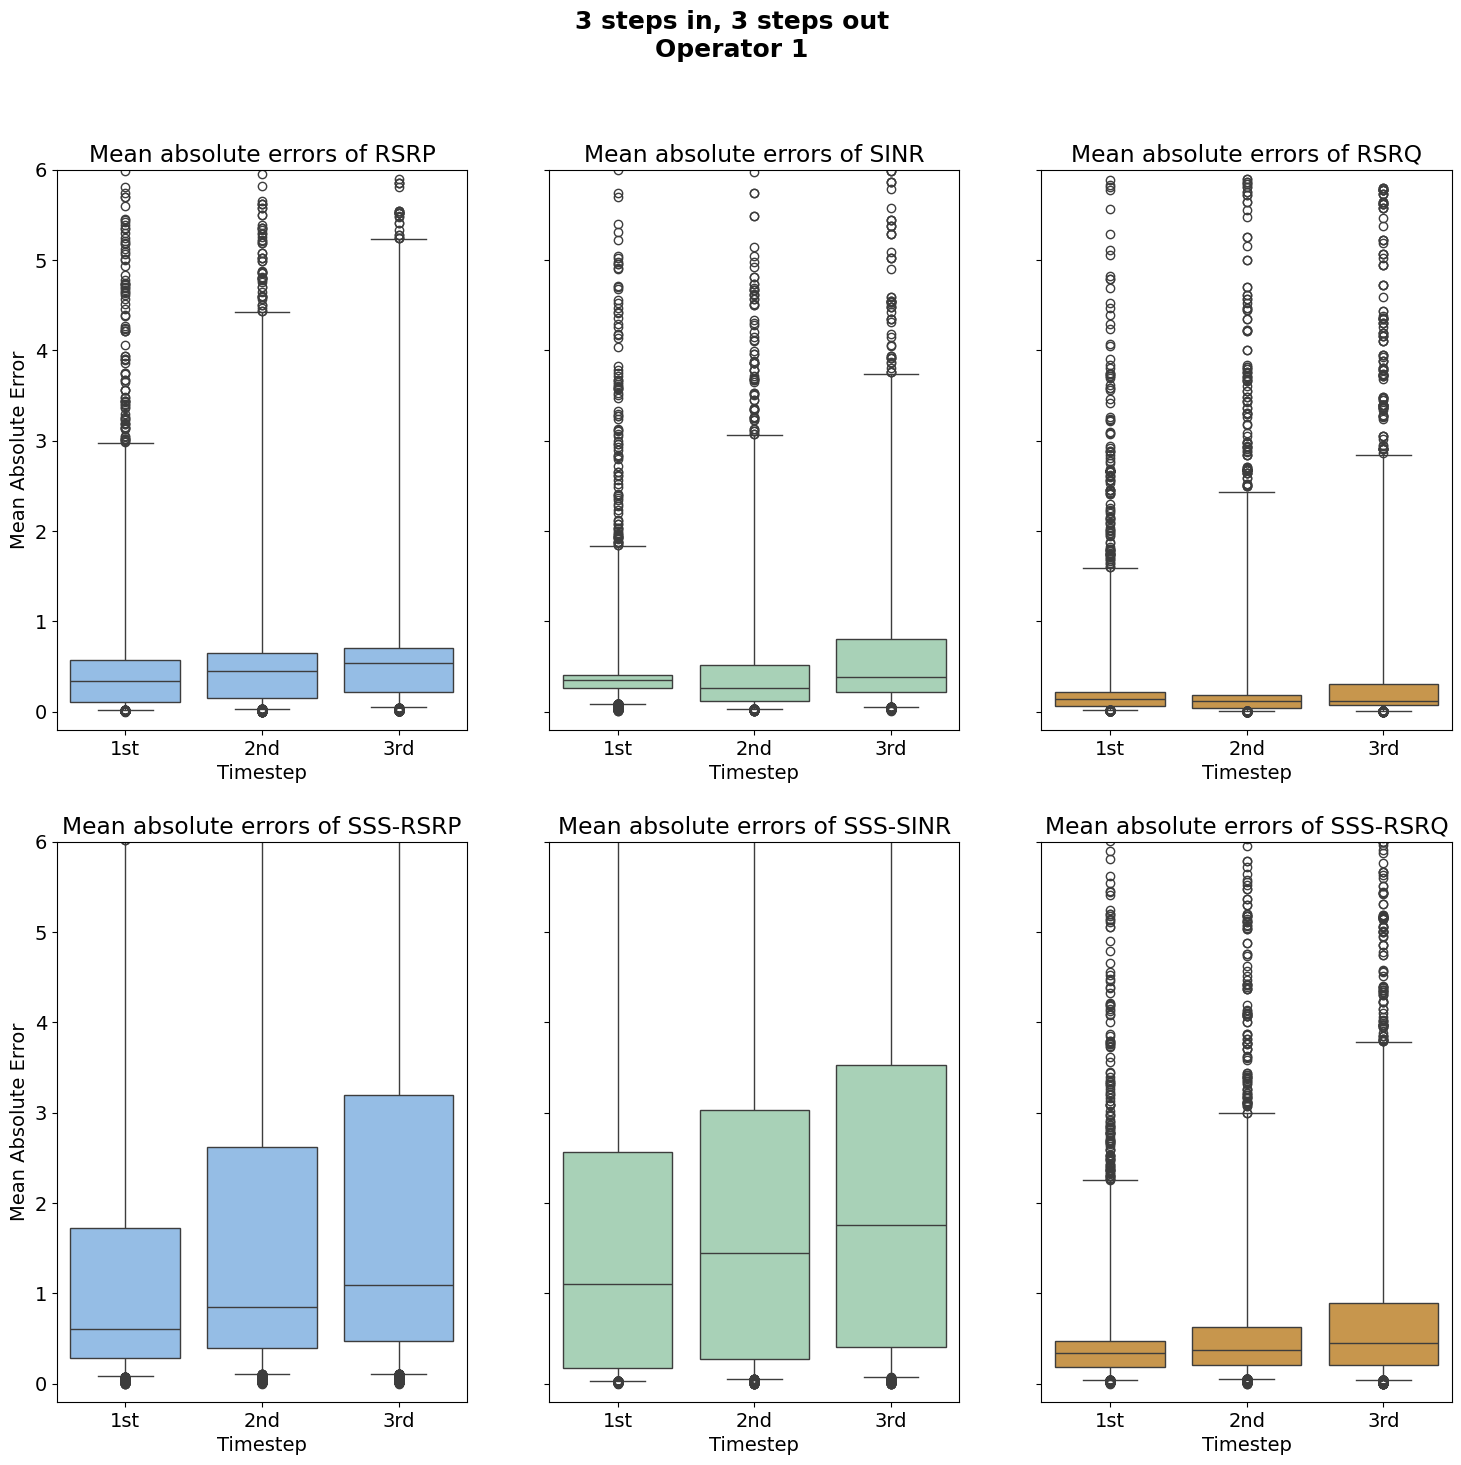

In [72]:
fig, mae_each_step = boxplot_timesteps(results=lstm_results, feature_comb=feature_comb, sss_feature_comb=sss_feature_comb, n_steps_in=n_steps_in, n_steps_out=n_steps_out, operator=operator, y_lim=6)
fig.savefig(r'../latex/plots/lstm/op1_box_3_steps_mae_zoom.pdf')

In [73]:
mae_each_step

,1st,2nd,3rd
RSRP,0.668,0.879,1.086
SINR,0.683,0.804,1.039
RSRQ,0.358,0.446,0.561
SSS-RSRP,1.500,1.923,2.254
SSS-SINR,1.815,2.192,2.514
SSS-RSRQ,0.589,0.759,0.912


## 5 Steps Prediction

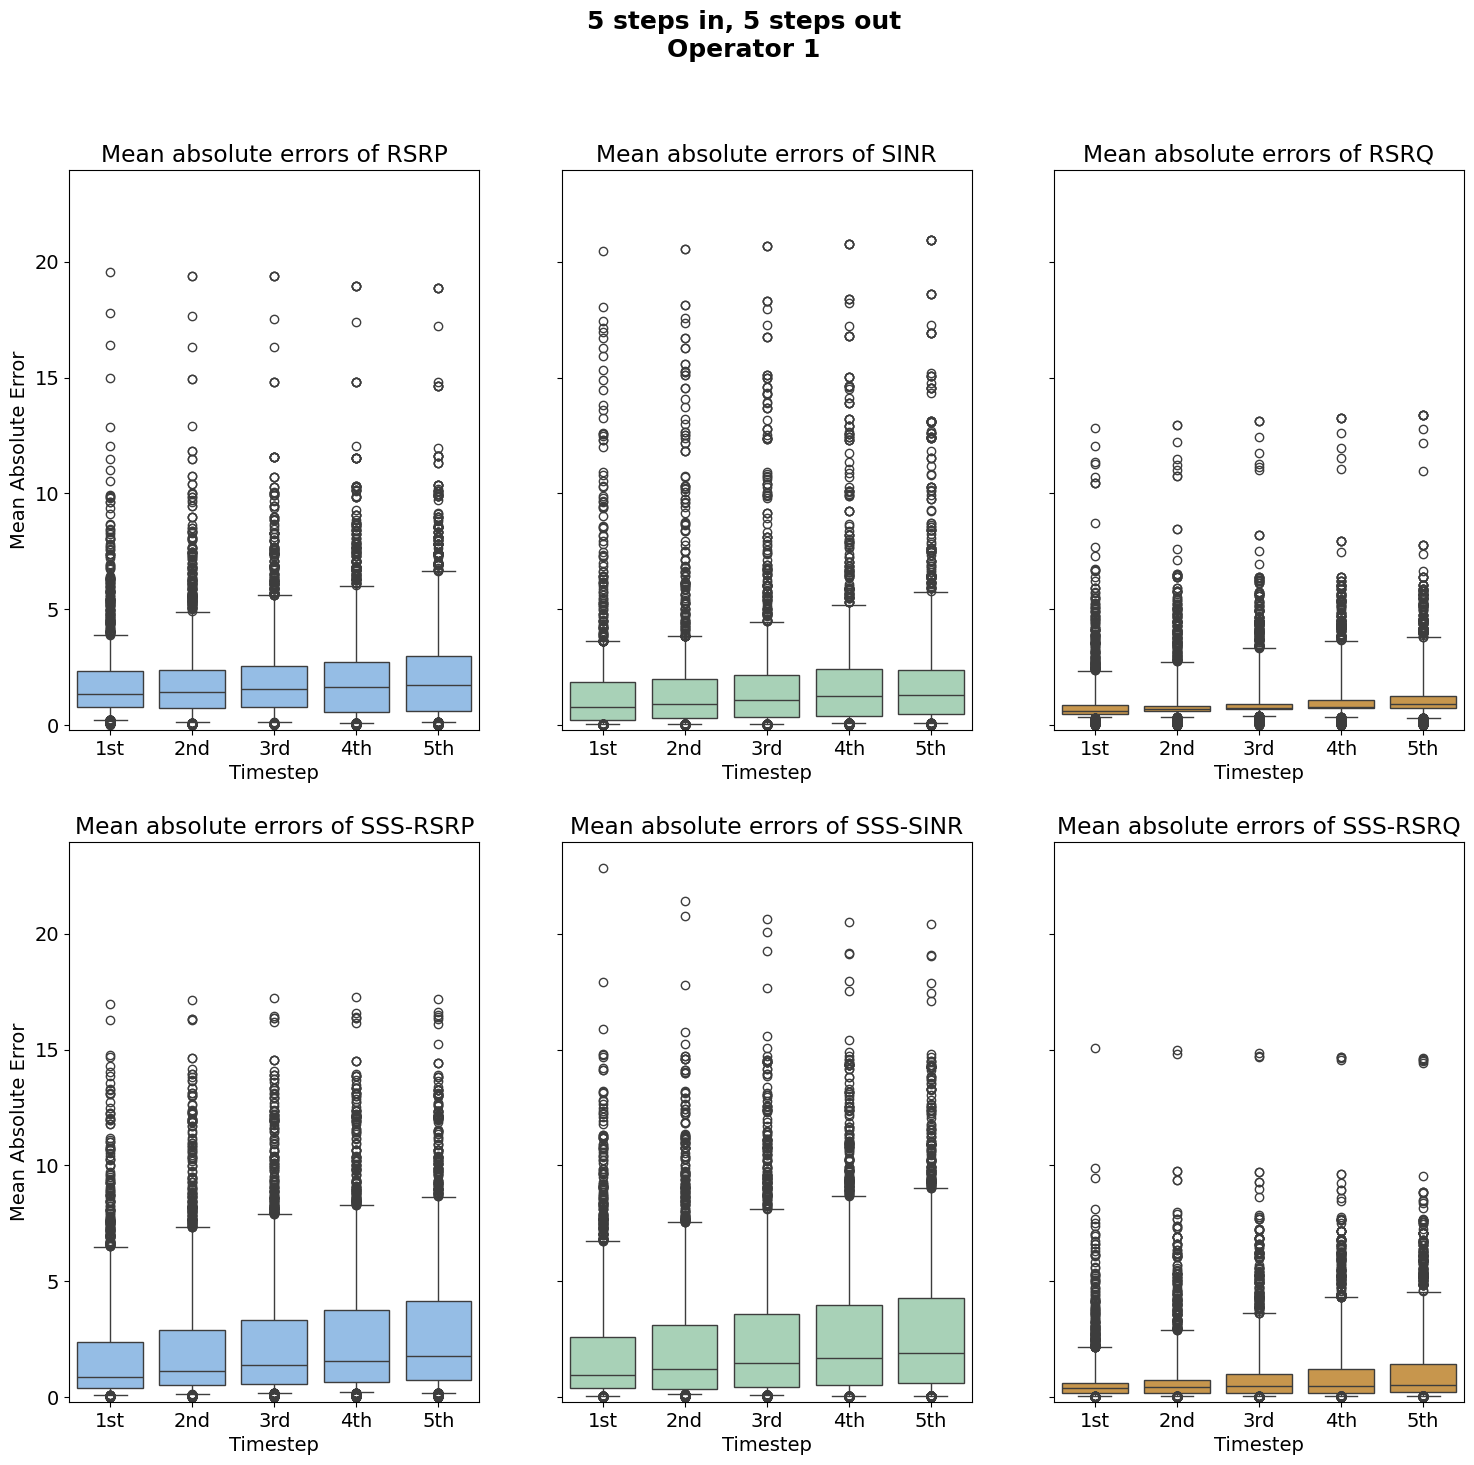

In [74]:
n_steps_in = 5
n_steps_out = 5

lstm_results = {}

for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            used_features = ''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(features)
            used_features = used_features + ' -> ' + target
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
            lstm_results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=units)
            df_lstm_results = pd.DataFrame.from_dict(lstm_results, orient='index')

fig, mae_each_step = boxplot_timesteps(results=lstm_results, feature_comb=feature_comb, sss_feature_comb=sss_feature_comb, n_steps_in=n_steps_in, n_steps_out=n_steps_out, operator=operator)
fig.savefig(r'../latex/plots/lstm/op1_box_5_steps_mae.pdf')

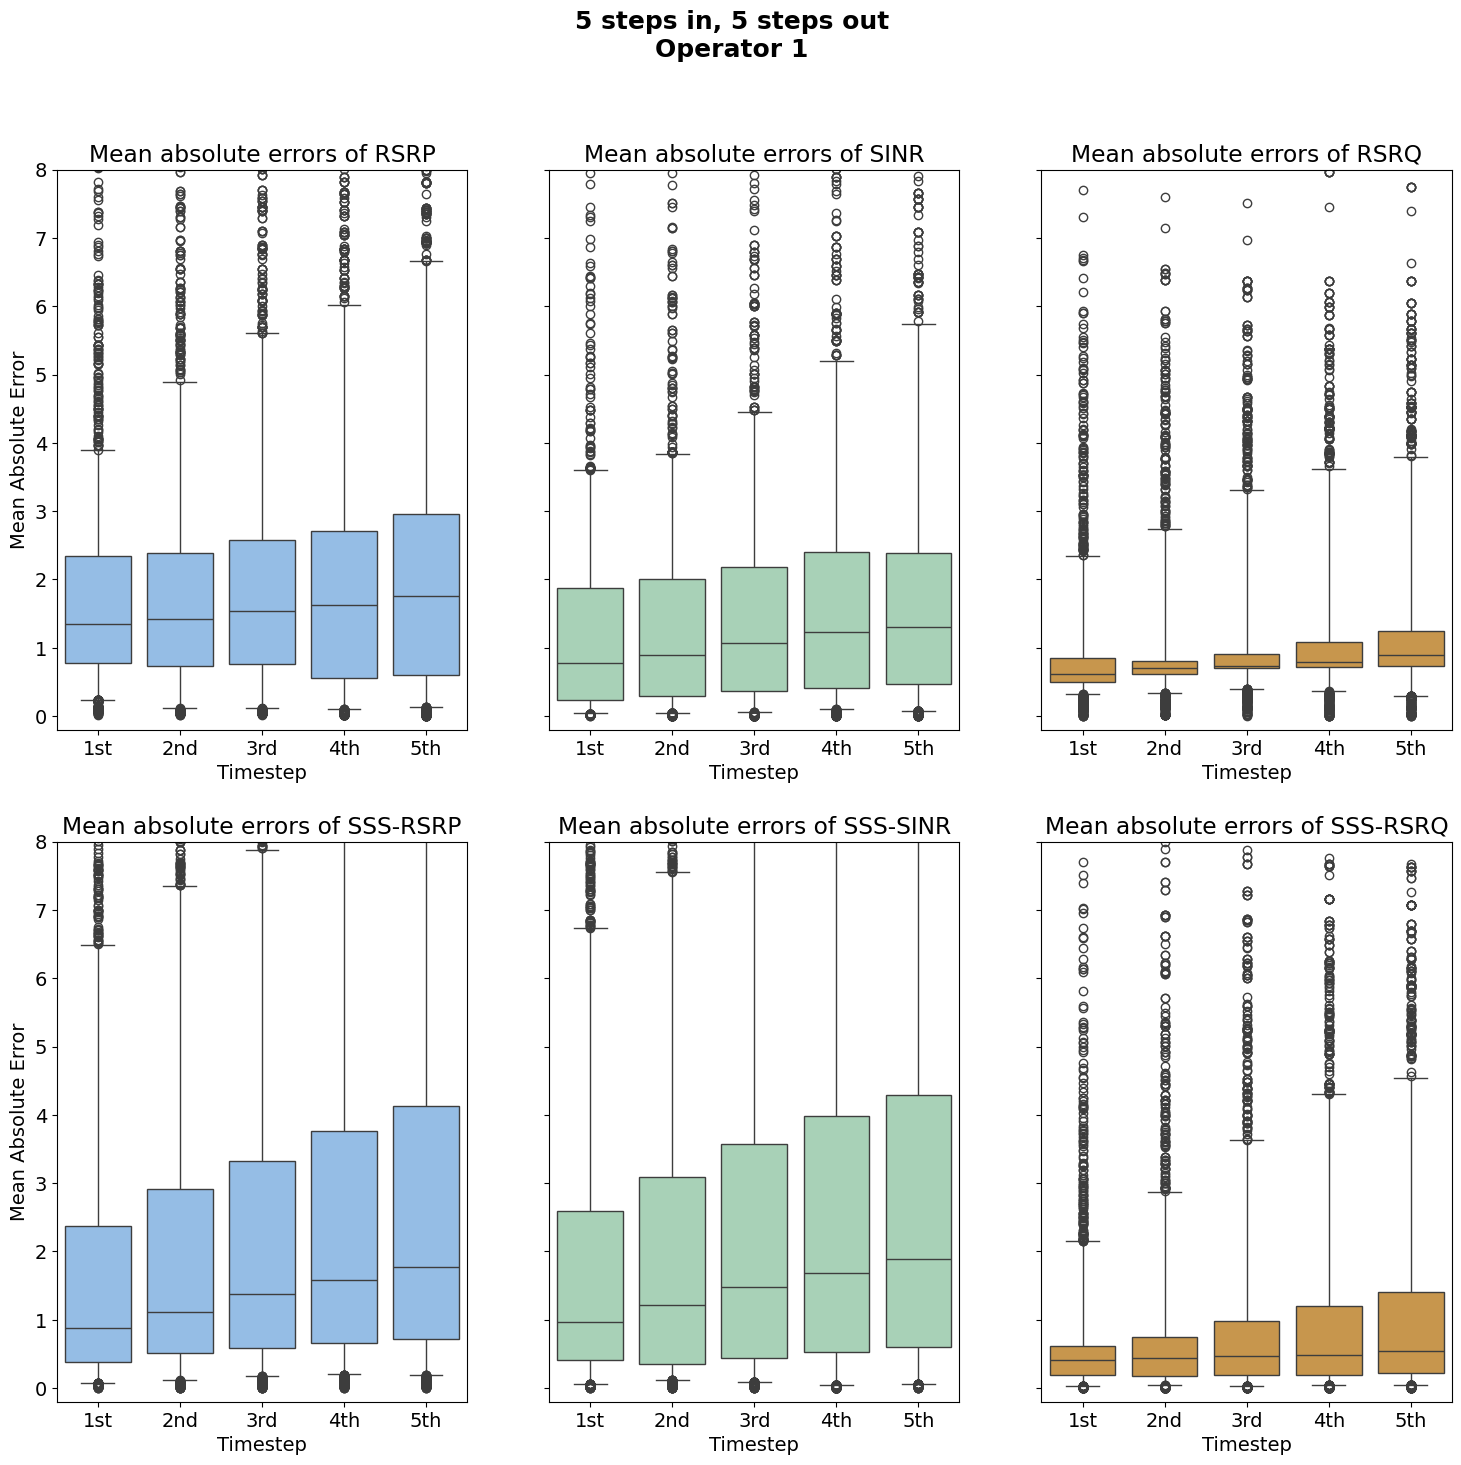

In [75]:
fig, mae_each_step = boxplot_timesteps(results=lstm_results, feature_comb=feature_comb, sss_feature_comb=sss_feature_comb, n_steps_in=n_steps_in, n_steps_out=n_steps_out, operator=operator, y_lim=8)
fig.savefig(r'../latex/plots/lstm/op1_box_5_steps_mae_zoom.pdf')

In [76]:
mae_each_step

,1st,2nd,3rd,4th,5th
RSRP,1.696,1.798,1.963,2.040,2.197
SINR,1.292,1.488,1.688,1.860,1.965
RSRQ,0.865,0.983,1.094,1.186,1.272
SSS-RSRP,1.804,2.132,2.403,2.628,2.815
SSS-SINR,1.878,2.208,2.481,2.709,2.903
SSS-RSRQ,0.633,0.778,0.917,1.043,1.156


## 10 Steps Prediction

Different steps back

### 1 step back

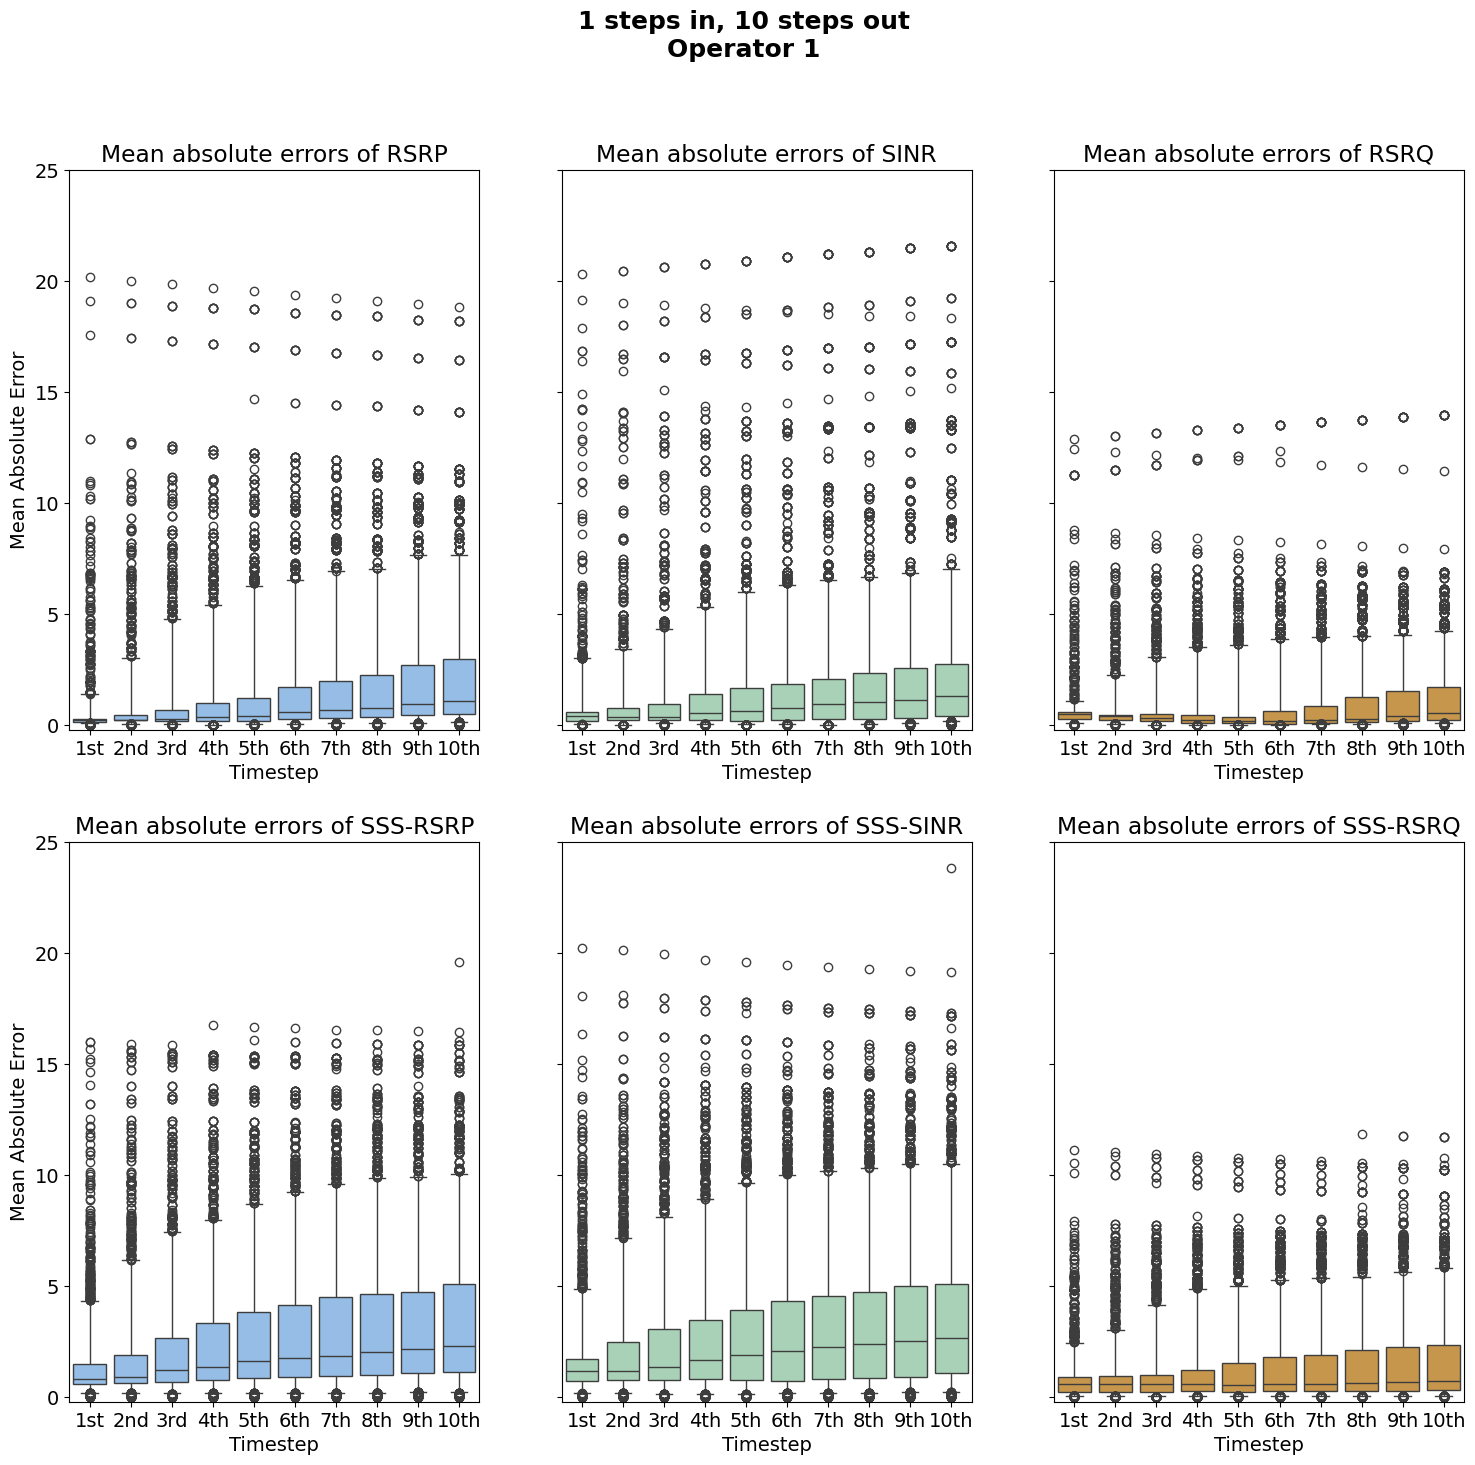

In [77]:
n_steps_in = 1
n_steps_out = 10

lstm_results = {}

for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            used_features = ''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(features)
            used_features = used_features + ' -> ' + target
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
            lstm_results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=units)
            df_lstm_results = pd.DataFrame.from_dict(lstm_results, orient='index')

fig, mae_each_step = boxplot_timesteps(results=lstm_results, feature_comb=feature_comb, sss_feature_comb=sss_feature_comb, n_steps_in=n_steps_in, n_steps_out=n_steps_out, operator=operator)
fig.savefig(r'../latex/plots/lstm/op1_box_1_in_10_out_mae.pdf')

In [78]:
mae_each_step

,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
RSRP,0.506,0.708,0.917,1.122,1.297,1.519,1.709,1.867,2.055,2.204
SINR,0.784,0.963,1.151,1.331,1.498,1.664,1.817,1.945,2.083,2.213
RSRQ,0.612,0.622,0.639,0.668,0.716,0.785,0.889,0.993,1.104,1.198
SSS-RSRP,1.344,1.792,2.162,2.470,2.721,2.919,3.079,3.232,3.350,3.470
SSS-SINR,1.620,2.038,2.392,2.684,2.918,3.101,3.257,3.403,3.510,3.624
SSS-RSRQ,0.808,0.914,1.028,1.136,1.231,1.322,1.397,1.470,1.534,1.595


### 2 steps back

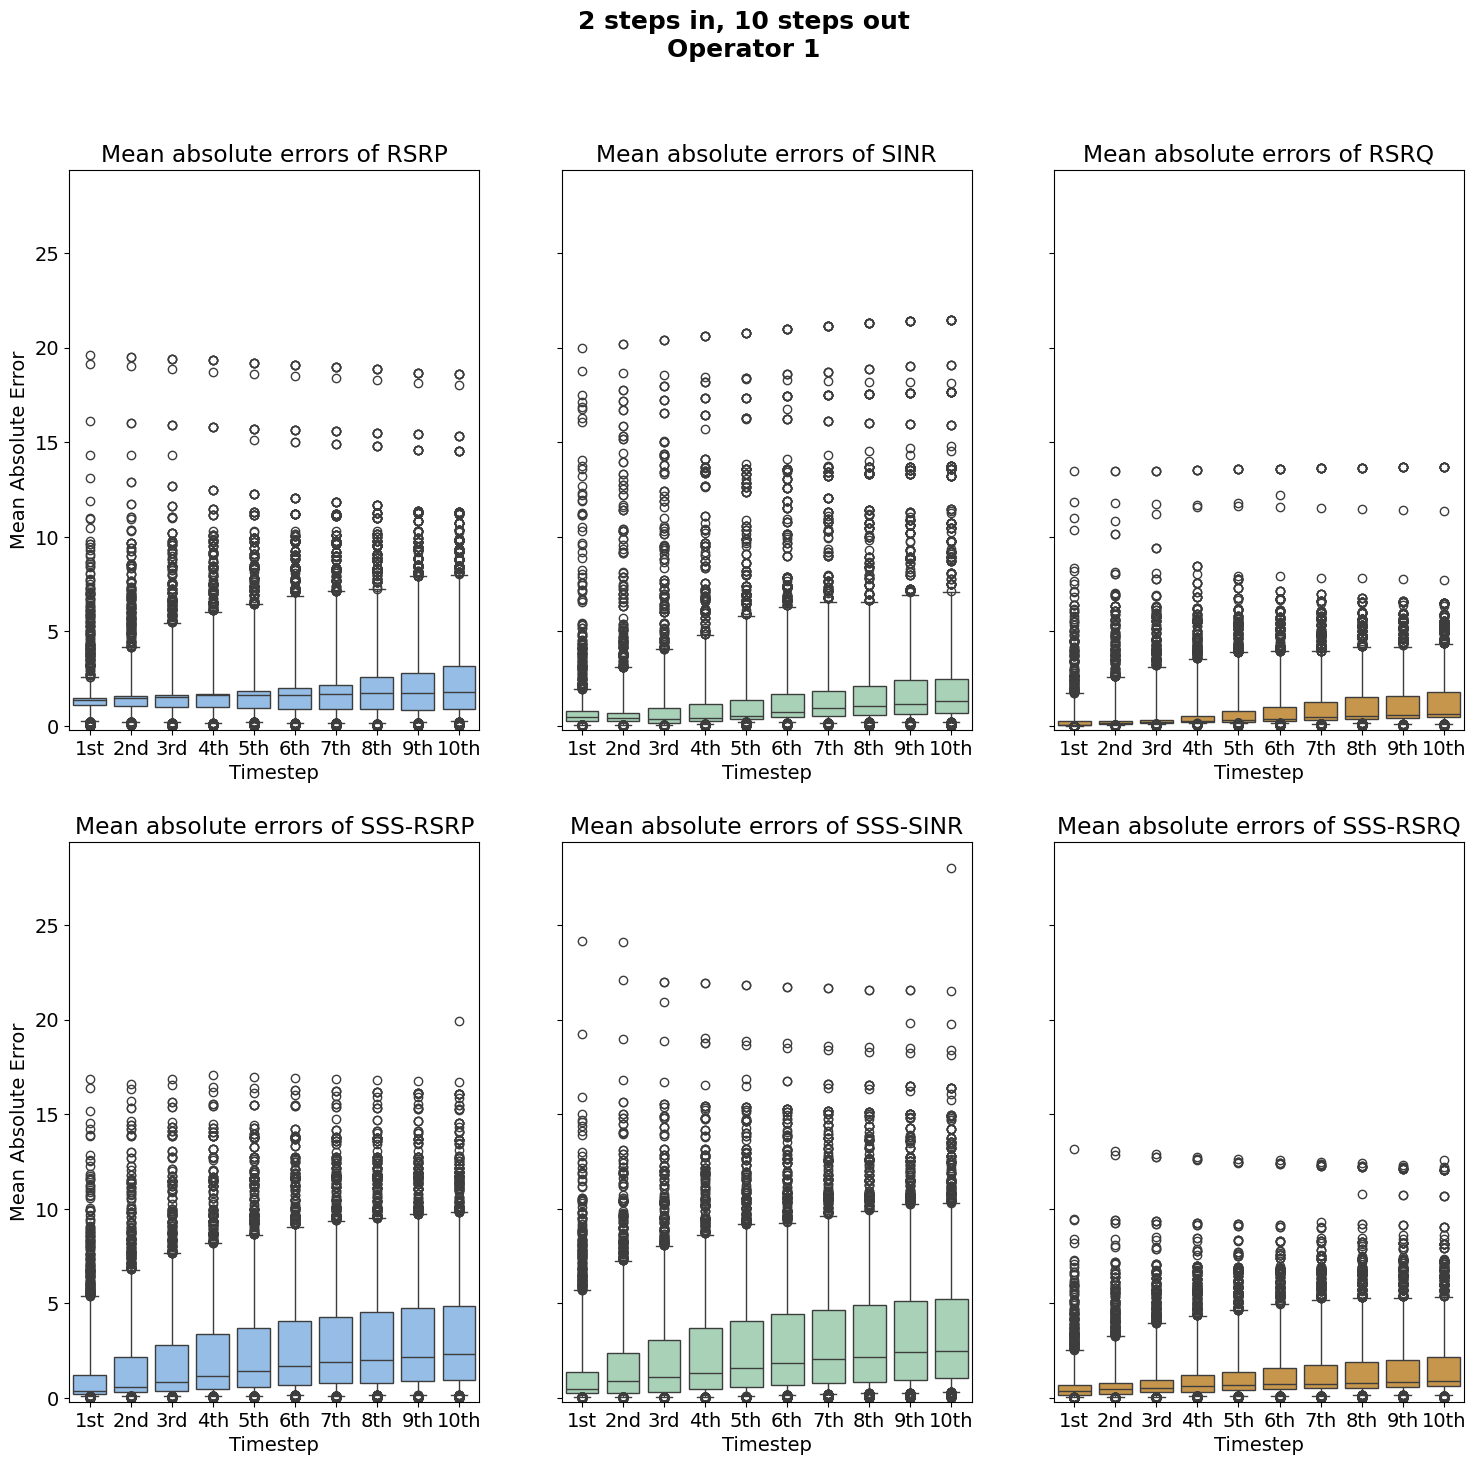

In [79]:
n_steps_in = 2
n_steps_out = 10

lstm_results = {}

for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            used_features = ''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(features)
            used_features = used_features + ' -> ' + target
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
            lstm_results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=units)
            df_lstm_results = pd.DataFrame.from_dict(lstm_results, orient='index')

fig, mae_each_step = boxplot_timesteps(results=lstm_results, feature_comb=feature_comb, sss_feature_comb=sss_feature_comb, n_steps_in=n_steps_in, n_steps_out=n_steps_out, operator=operator)
fig.savefig(r'../latex/plots/lstm/op1_box_2_in_10_out_mae.pdf')

In [80]:
mae_each_step

,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
RSRP,1.444,1.598,1.736,1.884,2.009,2.124,2.244,2.369,2.466,2.579
SINR,0.751,0.887,1.037,1.239,1.443,1.643,1.805,1.959,2.086,2.193
RSRQ,0.351,0.495,0.630,0.756,0.872,0.976,1.072,1.161,1.238,1.311
SSS-RSRP,1.222,1.673,2.048,2.363,2.606,2.806,2.983,3.127,3.251,3.360
SSS-SINR,1.392,1.838,2.214,2.532,2.780,2.997,3.183,3.330,3.448,3.556
SSS-RSRQ,0.635,0.822,0.987,1.127,1.260,1.365,1.457,1.536,1.613,1.681


### 3 steps back

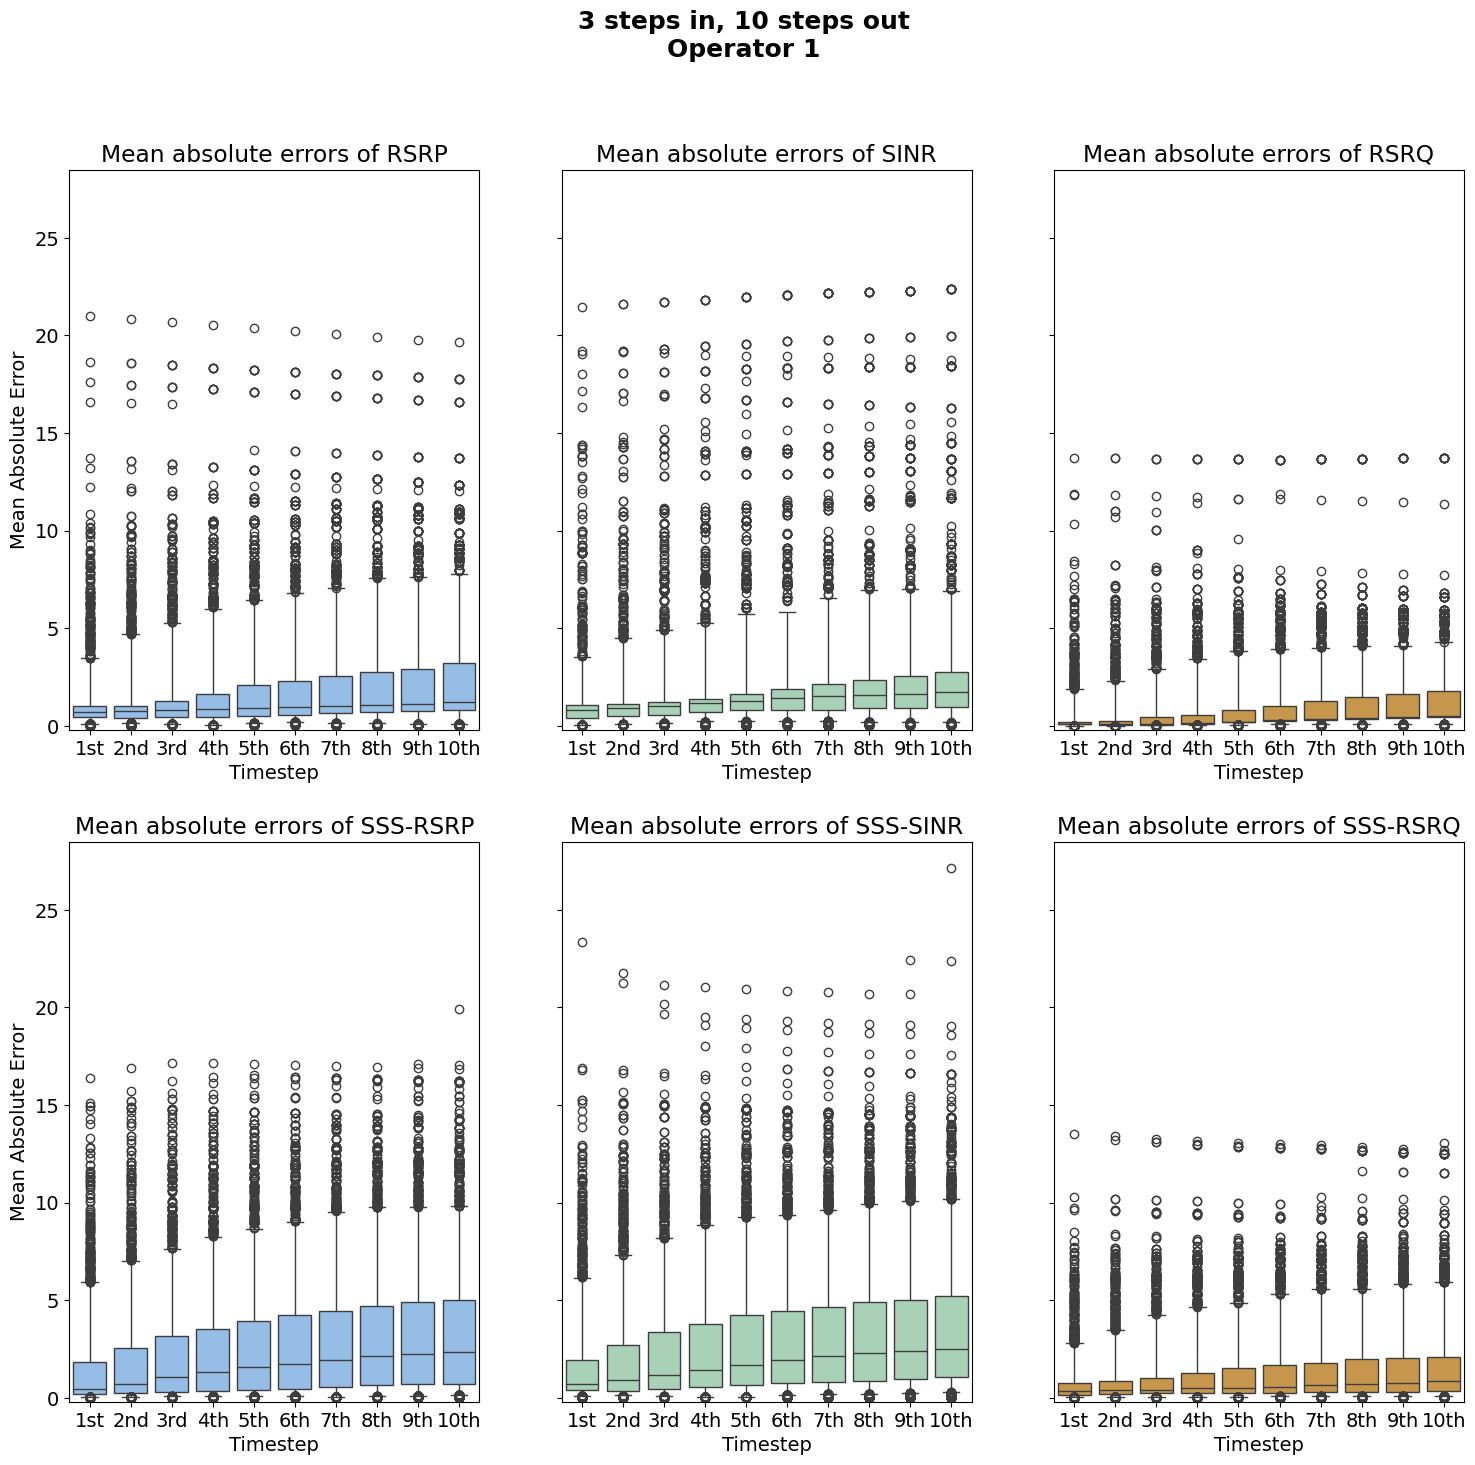

In [81]:
n_steps_in = 3
n_steps_out = 10

lstm_results = {}

for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            used_features = ''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(features)
            used_features = used_features + ' -> ' + target
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
            lstm_results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=units)
            df_lstm_results = pd.DataFrame.from_dict(lstm_results, orient='index')

fig, mae_each_step = boxplot_timesteps(results=lstm_results, feature_comb=feature_comb, sss_feature_comb=sss_feature_comb, n_steps_in=n_steps_in, n_steps_out=n_steps_out, operator=operator)
fig.savefig(r'../latex/plots/lstm/op1_box_3_in_10_out_mae.pdf')

In [82]:
mae_each_step

,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
RSRP,1.061,1.227,1.382,1.537,1.704,1.865,2.013,2.154,2.289,2.417
SINR,1.060,1.266,1.464,1.644,1.808,1.969,2.095,2.212,2.312,2.416
RSRQ,0.364,0.449,0.573,0.693,0.817,0.924,1.027,1.120,1.207,1.289
SSS-RSRP,1.436,1.841,2.169,2.432,2.644,2.829,2.992,3.131,3.251,3.354
SSS-SINR,1.621,2.019,2.349,2.611,2.833,3.030,3.190,3.322,3.438,3.541
SSS-RSRQ,0.719,0.867,0.998,1.117,1.216,1.310,1.392,1.467,1.535,1.596


### 5 steps back

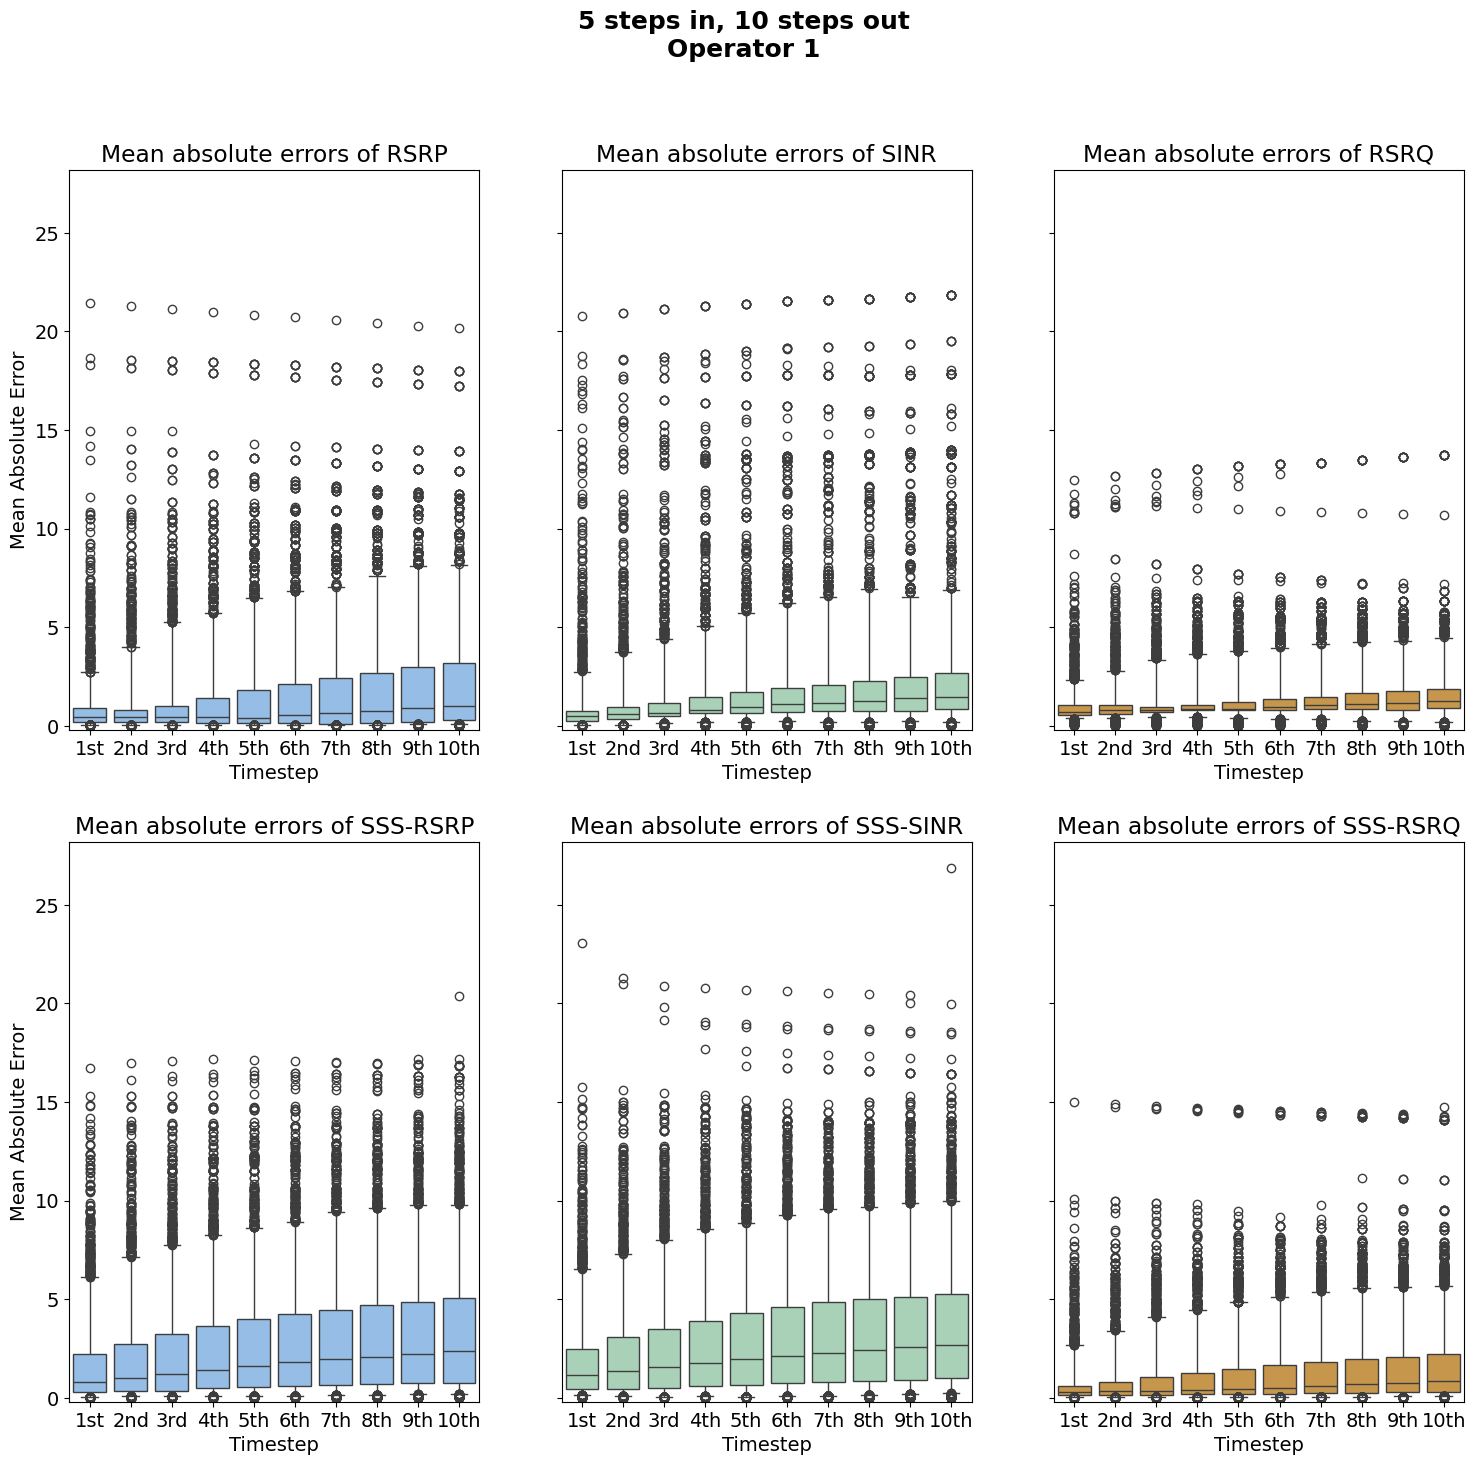

In [83]:
n_steps_in = 5
n_steps_out = 10

lstm_results = {}

for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            used_features = ''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(features)
            used_features = used_features + ' -> ' + target
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
            lstm_results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=units)
            df_lstm_results = pd.DataFrame.from_dict(lstm_results, orient='index')

fig, mae_each_step = boxplot_timesteps(results=lstm_results, feature_comb=feature_comb, sss_feature_comb=sss_feature_comb, n_steps_in=n_steps_in, n_steps_out=n_steps_out, operator=operator)
fig.savefig(r'../latex/plots/lstm/op1_box_5_in_10_out_mae.pdf')

In [84]:
mae_each_step

,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
RSRP,0.860,1.007,1.142,1.281,1.424,1.571,1.719,1.878,2.037,2.191
SINR,0.850,1.055,1.286,1.499,1.680,1.850,1.982,2.093,2.218,2.328
RSRQ,0.977,1.056,1.148,1.235,1.277,1.374,1.453,1.515,1.555,1.634
SSS-RSRP,1.649,1.989,2.271,2.507,2.708,2.882,3.030,3.158,3.276,3.384
SSS-SINR,1.890,2.221,2.493,2.724,2.918,3.085,3.231,3.357,3.465,3.565
SSS-RSRQ,0.665,0.800,0.931,1.053,1.168,1.272,1.364,1.446,1.518,1.583


### 10 steps back

In [85]:
n_steps_in = 10
n_steps_out = 10

lstm_results = {}

for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            used_features = ''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(features)
            used_features = used_features + ' -> ' + target
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
            lstm_results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=units)
            df_lstm_results = pd.DataFrame.from_dict(lstm_results, orient='index')

df_lstm_results.reset_index(inplace=True)
df_lstm_results.rename(columns={'index': 'Combination'}, inplace=True)
df_lstm_results = df_lstm_results.drop(['y_pred', 'y_true', 'train_pred', 'train_true', 'loss', 'val_loss', 'list_mae', 'train_list_mae'], axis=1)
df_lstm_results

,Combination,loss_final,val_loss_final,mae,train_mae
0,RSRP -> RSRP,0.01064,0.00904,1.61,2.41
1,"RSRP, SSS_RSRP -> RSRP",0.01455,0.01219,2.52,3.20
2,SINR -> SINR,0.00808,0.01386,2.49,3.88
3,"SINR, SSS_SINR -> SINR",0.00669,0.06201,2.23,3.94
4,RSRQ -> RSRQ,0.01665,0.00590,0.95,1.15
5,"RSRQ, SSS_RSRQ -> RSRQ",0.01667,0.00971,1.61,1.75
6,SSS_RSRP -> SSS_RSRP,0.00743,0.00419,2.87,2.59
7,"RSRP, SSS_RSRP -> SSS_RSRP",0.00695,0.00453,2.86,2.50
8,SSS_SINR -> SSS_SINR,0.00951,0.00623,2.85,2.54
9,"SINR, SSS_SINR -> SSS_SINR",0.00934,0.00631,2.97,2.64


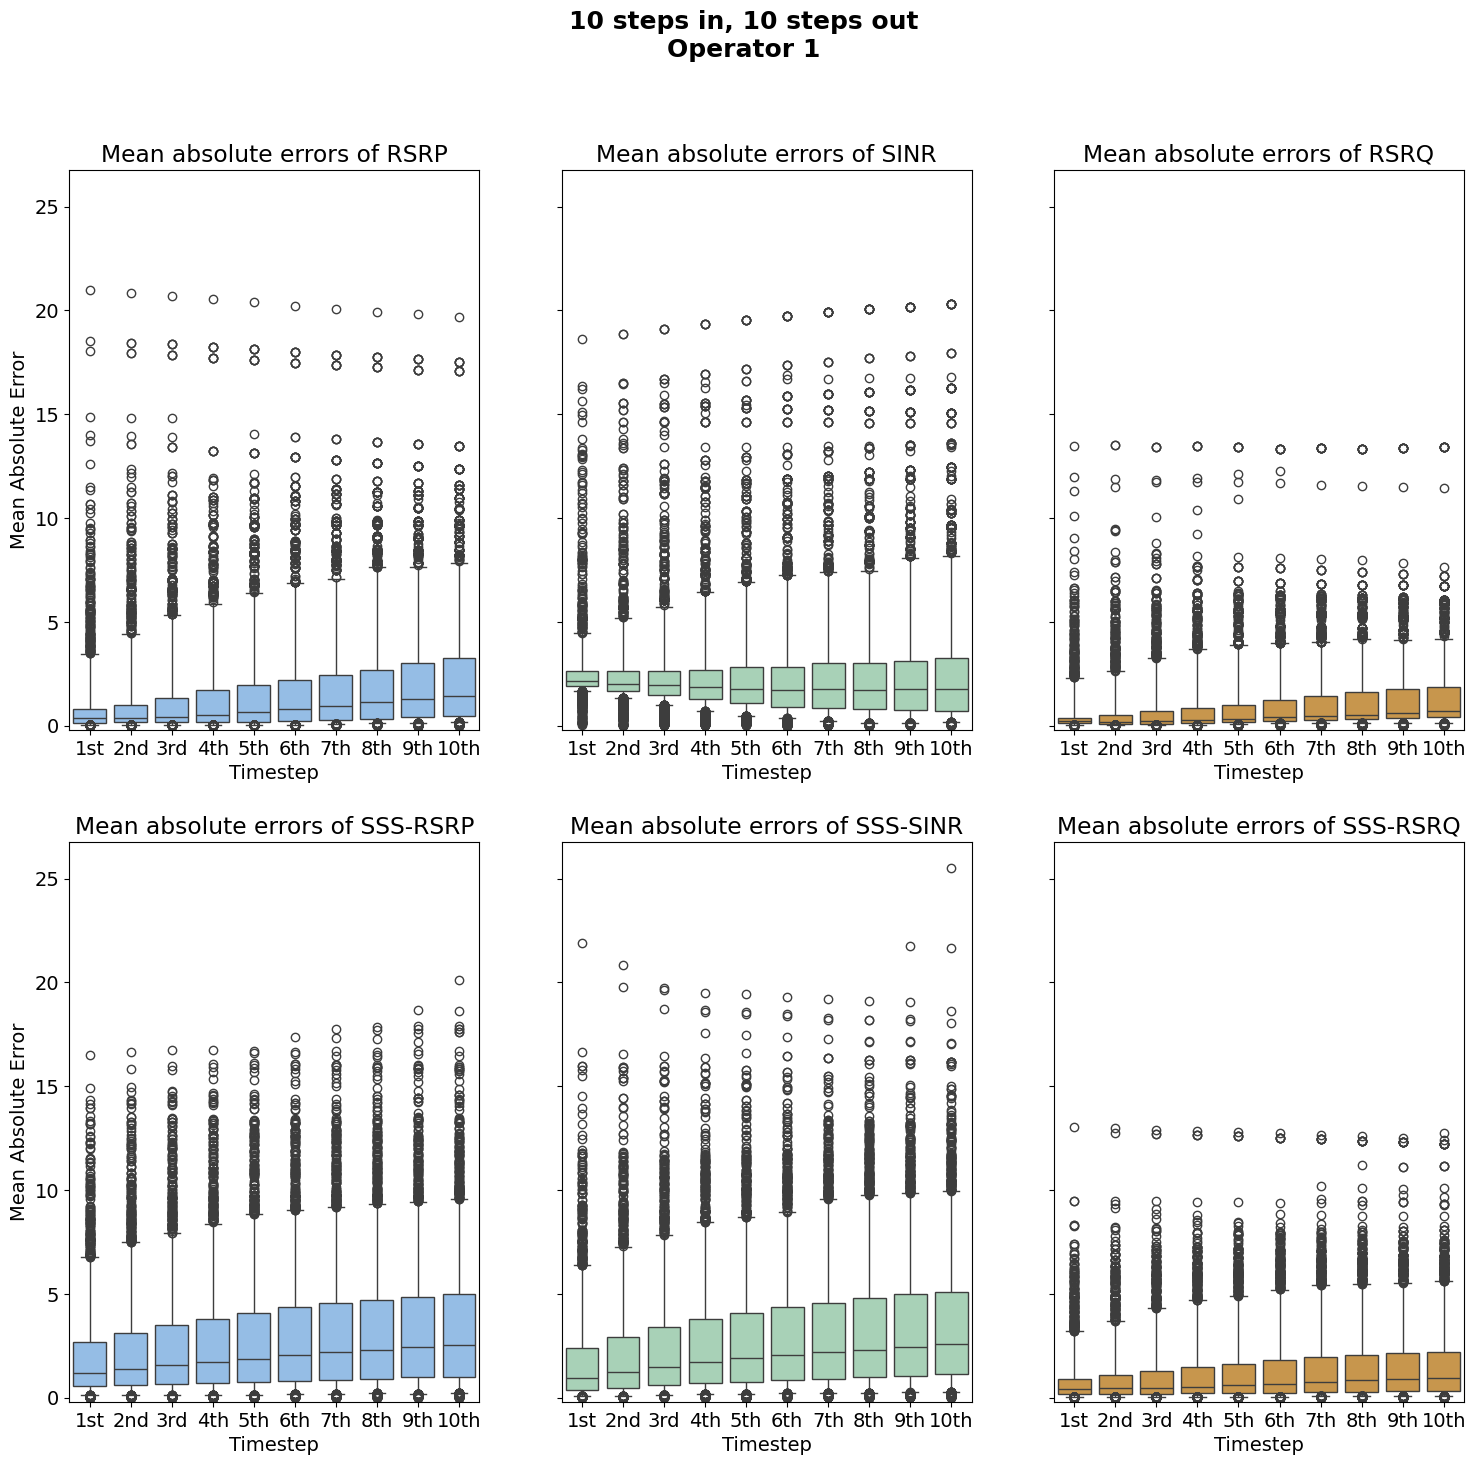

In [86]:
fig, mae_each_step = boxplot_timesteps(results=lstm_results, feature_comb=feature_comb, sss_feature_comb=sss_feature_comb, n_steps_in=n_steps_in, n_steps_out=n_steps_out, operator=operator)
fig.savefig(r'../latex/plots/lstm/op1_box_10_in_10_out_mae.pdf')

In [87]:
mae_each_step

,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
RSRP,0.843,1.009,1.178,1.350,1.526,1.708,1.887,2.055,2.211,2.360
SINR,2.543,2.496,2.493,2.469,2.447,2.442,2.465,2.489,2.535,2.569
RSRQ,0.512,0.598,0.699,0.816,0.918,1.020,1.115,1.208,1.288,1.369
SSS-RSRP,2.030,2.293,2.513,2.701,2.867,3.019,3.152,3.265,3.374,3.465
SSS-SINR,1.793,2.139,2.436,2.682,2.885,3.058,3.207,3.336,3.439,3.542
SSS-RSRQ,0.819,0.936,1.047,1.151,1.246,1.332,1.414,1.485,1.549,1.601


### 20 steps back

In [88]:
n_steps_in = 20
n_steps_out = 10

lstm_results = {}

for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            used_features = ''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(features)
            used_features = used_features + ' -> ' + target
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
            lstm_results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=units)
            df_lstm_results = pd.DataFrame.from_dict(lstm_results, orient='index')

df_lstm_results.reset_index(inplace=True)
df_lstm_results.rename(columns={'index': 'Combination'}, inplace=True)
df_lstm_results = df_lstm_results.drop(['y_pred', 'y_true', 'train_pred', 'train_true', 'loss', 'val_loss', 'list_mae', 'train_list_mae'], axis=1)
df_lstm_results

,Combination,loss_final,val_loss_final,mae,train_mae
0,RSRP -> RSRP,0.01091,0.00943,1.64,2.45
1,"RSRP, SSS_RSRP -> RSRP",0.00981,0.03268,3.15,4.12
2,SINR -> SINR,0.00590,0.00988,1.83,2.53
3,"SINR, SSS_SINR -> SINR",0.00657,0.00699,1.83,2.65
4,RSRQ -> RSRQ,0.01593,0.00609,0.96,1.10
5,"RSRQ, SSS_RSRQ -> RSRQ",0.01413,0.00824,1.50,1.31
6,SSS_RSRP -> SSS_RSRP,0.00723,0.00555,3.14,2.86
7,"RSRP, SSS_RSRP -> SSS_RSRP",0.00805,0.00817,3.73,3.46
8,SSS_SINR -> SSS_SINR,0.00949,0.00644,2.88,2.66
9,"SINR, SSS_SINR -> SSS_SINR",0.00904,0.00659,3.00,2.71


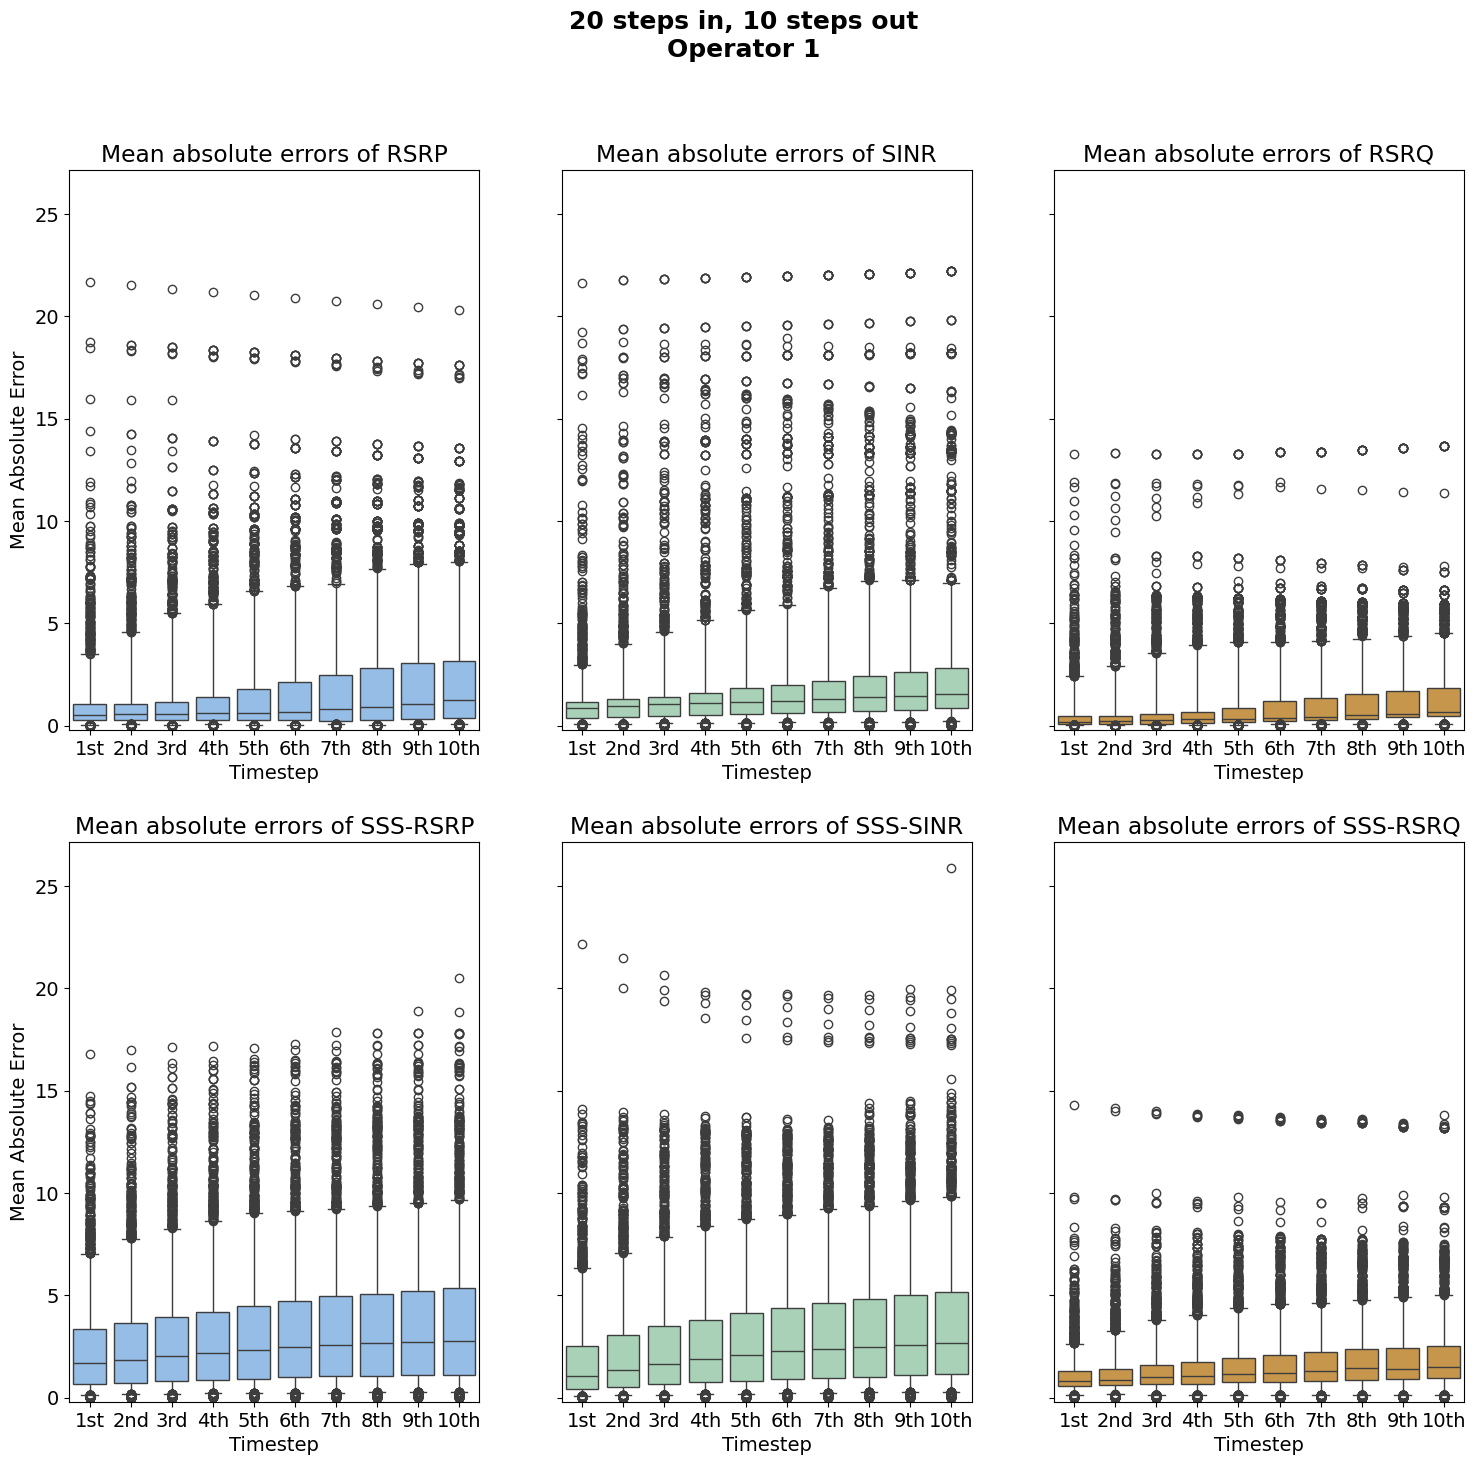

In [89]:
fig, mae_each_step = boxplot_timesteps(results=lstm_results, feature_comb=feature_comb, sss_feature_comb=sss_feature_comb, n_steps_in=n_steps_in, n_steps_out=n_steps_out, operator=operator)
fig.savefig(r'../latex/plots/lstm/op1_box_20_in_10_out_mae.pdf')

In [90]:
mae_each_step

,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
RSRP,0.982,1.126,1.266,1.412,1.556,1.707,1.858,2.012,2.161,2.306
SINR,1.110,1.329,1.508,1.663,1.808,1.942,2.065,2.181,2.296,2.413
RSRQ,0.531,0.627,0.720,0.816,0.918,1.013,1.106,1.199,1.282,1.362
SSS-RSRP,2.392,2.618,2.817,2.991,3.140,3.276,3.392,3.495,3.586,3.662
SSS-SINR,1.873,2.223,2.504,2.736,2.922,3.079,3.213,3.331,3.434,3.529
SSS-RSRQ,1.051,1.188,1.345,1.447,1.577,1.640,1.740,1.856,1.867,1.930


### 30 steps back

In [91]:
n_steps_in = 30
n_steps_out = 10

lstm_results = {}

for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            used_features = ''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(features)
            used_features = used_features + ' -> ' + target
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
            lstm_results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=units)
            df_lstm_results = pd.DataFrame.from_dict(lstm_results, orient='index')

df_lstm_results.reset_index(inplace=True)
df_lstm_results.rename(columns={'index': 'Combination'}, inplace=True)
df_lstm_results = df_lstm_results.drop(['y_pred', 'y_true', 'train_pred', 'train_true', 'loss', 'val_loss', 'list_mae', 'train_list_mae'], axis=1)
df_lstm_results

,Combination,loss_final,val_loss_final,mae,train_mae
0,RSRP -> RSRP,0.01085,0.00991,2.42,3.10
1,"RSRP, SSS_RSRP -> RSRP",0.00982,0.03049,2.95,3.74
2,SINR -> SINR,0.00667,0.02047,2.15,3.35
3,"SINR, SSS_SINR -> SINR",0.00591,0.02001,2.97,4.07
4,RSRQ -> RSRQ,0.01553,0.00670,1.17,1.26
5,"RSRQ, SSS_RSRQ -> RSRQ",0.01448,0.00791,1.35,1.22
6,SSS_RSRP -> SSS_RSRP,0.00705,0.00428,2.92,2.57
7,"RSRP, SSS_RSRP -> SSS_RSRP",0.00670,0.00577,3.07,2.66
8,SSS_SINR -> SSS_SINR,0.00984,0.00627,2.89,2.64
9,"SINR, SSS_SINR -> SSS_SINR",0.00849,0.02975,3.14,3.11


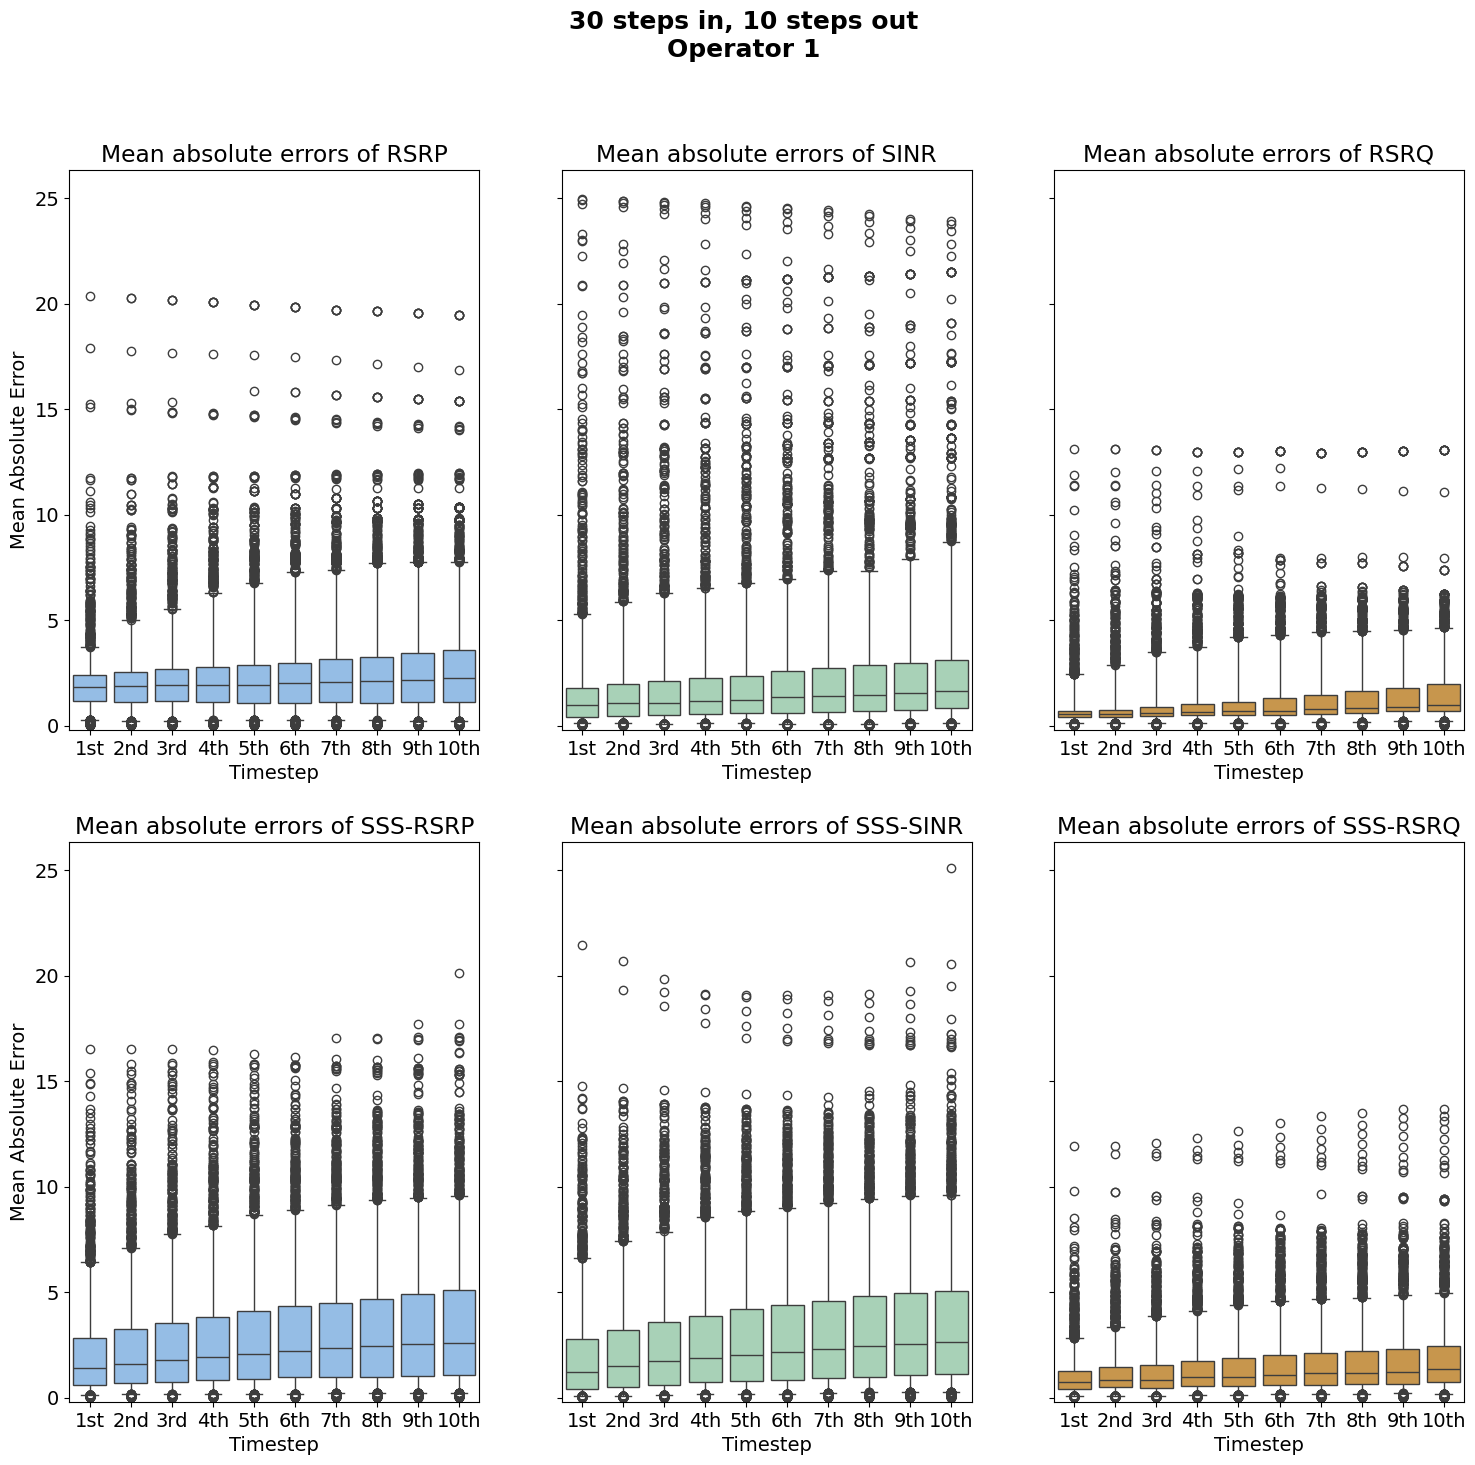

In [92]:
fig, mae_each_step = boxplot_timesteps(results=lstm_results, feature_comb=feature_comb, sss_feature_comb=sss_feature_comb, n_steps_in=n_steps_in, n_steps_out=n_steps_out, operator=operator)
fig.savefig(r'../latex/plots/lstm/op1_box_30_in_10_out_mae.pdf')

In [93]:
mae_each_step

,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
RSRP,1.910,2.052,2.182,2.279,2.379,2.492,2.581,2.680,2.767,2.855
SINR,1.668,1.799,1.912,2.031,2.121,2.233,2.323,2.402,2.471,2.566
RSRQ,0.757,0.847,0.959,1.066,1.151,1.220,1.318,1.401,1.476,1.548
SSS-RSRP,2.105,2.362,2.575,2.769,2.937,3.075,3.186,3.288,3.382,3.475
SSS-SINR,1.990,2.289,2.538,2.748,2.923,3.067,3.193,3.304,3.400,3.491
SSS-RSRQ,0.994,1.159,1.234,1.383,1.443,1.549,1.612,1.674,1.731,1.828


### 40 steps back

In [94]:
n_steps_in = 40
n_steps_out = 10

lstm_results = {}

for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            used_features = ''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(features)
            used_features = used_features + ' -> ' + target
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
            lstm_results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=units)
            df_lstm_results = pd.DataFrame.from_dict(lstm_results, orient='index')

df_lstm_results.reset_index(inplace=True)
df_lstm_results.rename(columns={'index': 'Combination'}, inplace=True)
df_lstm_results = df_lstm_results.drop(['y_pred', 'y_true', 'train_pred', 'train_true', 'loss', 'val_loss', 'list_mae', 'train_list_mae'], axis=1)
df_lstm_results

,Combination,loss_final,val_loss_final,mae,train_mae
0,RSRP -> RSRP,0.01218,0.01156,2.67,3.37
1,"RSRP, SSS_RSRP -> RSRP",0.00960,0.02109,3.43,4.37
2,SINR -> SINR,0.00700,0.01692,1.98,3.30
3,"SINR, SSS_SINR -> SINR",0.00535,0.01545,2.55,2.89
4,RSRQ -> RSRQ,0.01440,0.00889,1.44,1.48
5,"RSRQ, SSS_RSRQ -> RSRQ",0.01321,0.01944,2.05,1.84
6,SSS_RSRP -> SSS_RSRP,0.00704,0.00380,2.94,2.44
7,"RSRP, SSS_RSRP -> SSS_RSRP",0.00699,0.01235,3.34,2.88
8,SSS_SINR -> SSS_SINR,0.00956,0.00754,3.09,3.01
9,"SINR, SSS_SINR -> SSS_SINR",0.00905,0.01051,3.56,3.10


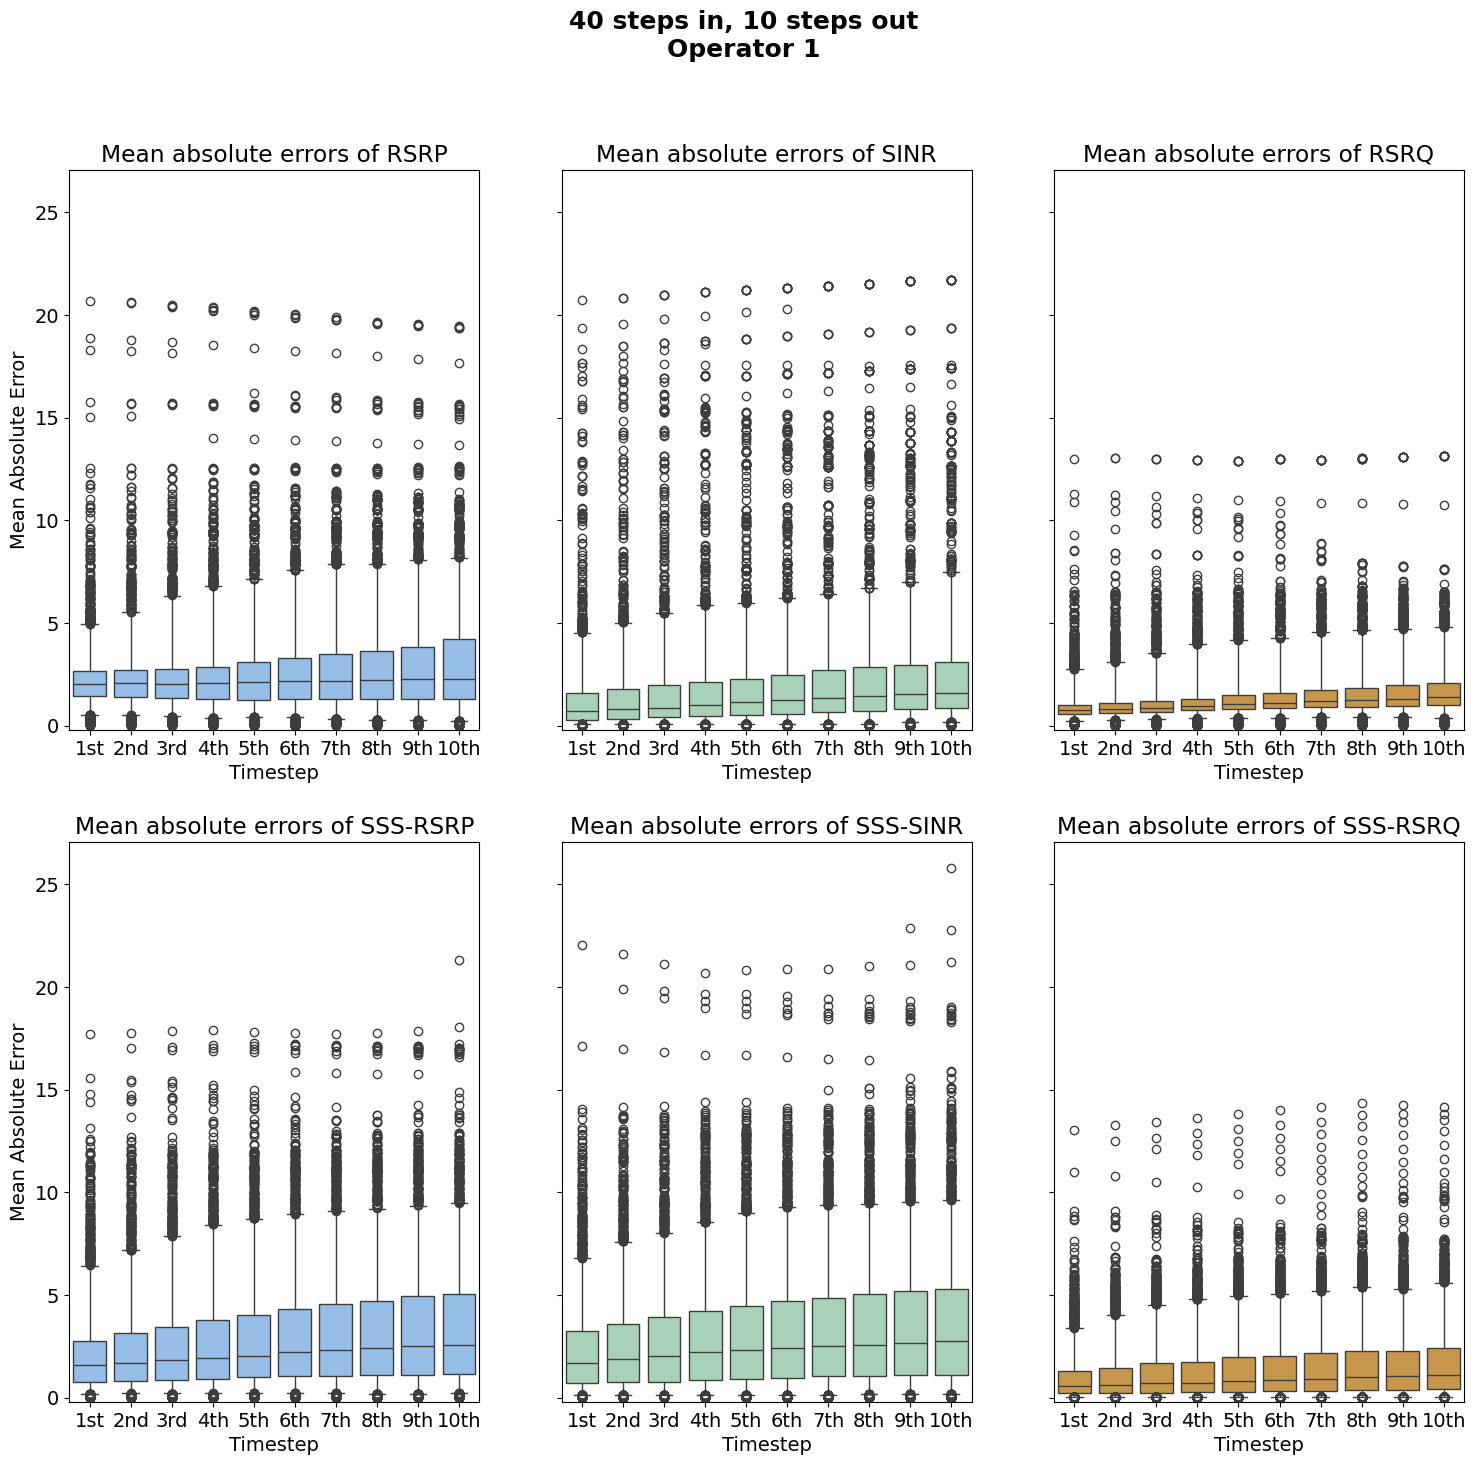

In [95]:
fig, mae_each_step = boxplot_timesteps(results=lstm_results, feature_comb=feature_comb, sss_feature_comb=sss_feature_comb, n_steps_in=n_steps_in, n_steps_out=n_steps_out, operator=operator)
fig.savefig(r'../latex/plots/lstm/op1_box_40_in_10_out_mae.pdf')

In [96]:
mae_each_step

,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
RSRP,2.270,2.378,2.455,2.536,2.634,2.731,2.807,2.880,2.969,3.060
SINR,1.355,1.517,1.677,1.837,1.960,2.095,2.197,2.305,2.392,2.483
RSRQ,0.981,1.083,1.194,1.320,1.453,1.525,1.631,1.677,1.727,1.798
SSS-RSRP,2.162,2.403,2.608,2.787,2.949,3.086,3.200,3.300,3.391,3.469
SSS-SINR,2.345,2.581,2.772,2.956,3.099,3.233,3.350,3.438,3.522,3.593
SSS-RSRQ,0.989,1.110,1.231,1.295,1.411,1.465,1.544,1.645,1.639,1.740
